# χ-square tests

In [4]:
from src.stats_comp import compatibility_corpus
from src.utils.utils import make_chisquare_test

all_corpus_comp_scores = compatibility_corpus('data/compiled/triads')
all_corpus_comp_baseline_scores = compatibility_corpus('data/compiled/baselines/triads/prose')

# Output
chi2_stat, degrees_of_freedom, p_value, sorted_keys, obs_counts, obs_total, exp_counts = make_chisquare_test(all_corpus_comp_scores, all_corpus_comp_baseline_scores)
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print(f"P-value: {p_value:.3e}")

Chi-square statistic: 445.0071
Degrees of freedom: 22
P-value: 2.002e-80


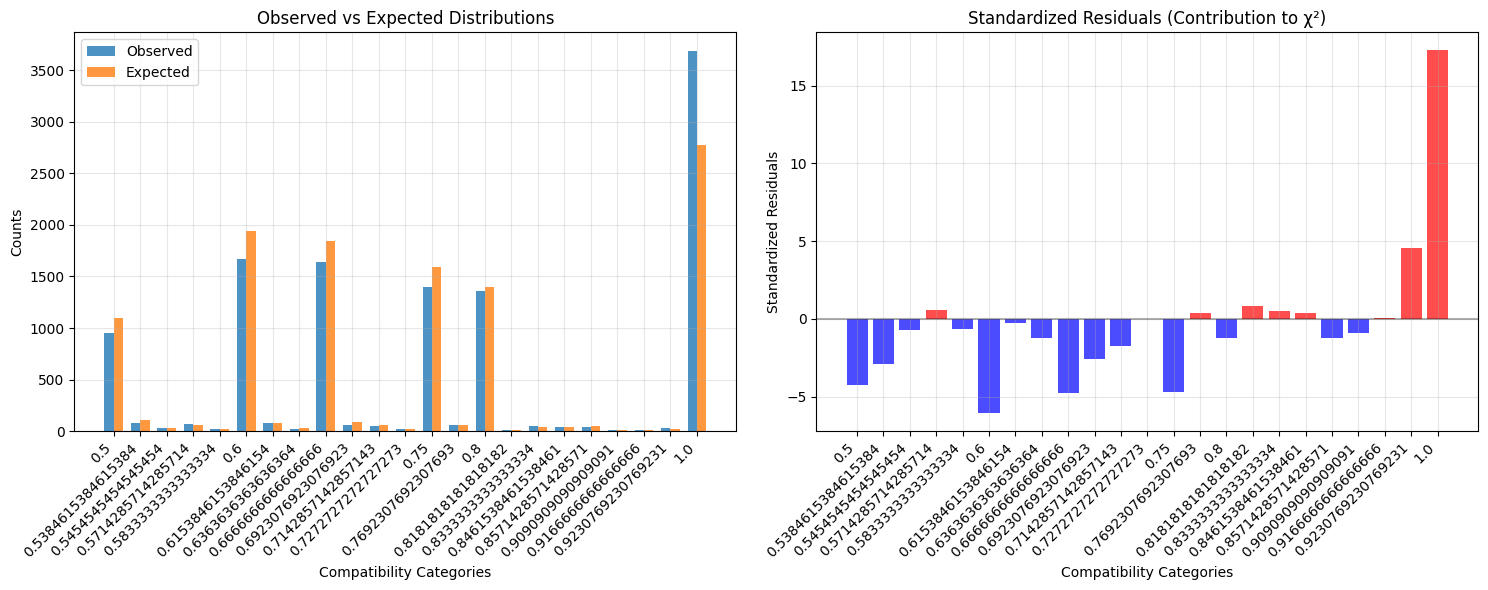


Contribution Analysis:
------------------------------------------------------------
            0.5: Obs= 956, Exp=1097.1, Residual= -4.26, Contrib= 18.16
0.5384615384615384: Obs=  76, Exp= 105.7, Residual= -2.89, Contrib=  8.37
0.5454545454545454: Obs=  28, Exp=  31.9, Residual= -0.70, Contrib=  0.49
0.5714285714285714: Obs=  66, Exp=  61.7, Residual=  0.55, Contrib=  0.30
0.5833333333333334: Obs=  19, Exp=  22.0, Residual= -0.65, Contrib=  0.42
            0.6: Obs=1671, Exp=1937.6, Residual= -6.06, Contrib= 36.69
0.6153846153846154: Obs=  79, Exp=  81.5, Residual= -0.28, Contrib=  0.08
0.6363636363636364: Obs=  22, Exp=  28.6, Residual= -1.24, Contrib=  1.54
0.6666666666666666: Obs=1642, Exp=1848.4, Residual= -4.80, Contrib= 23.05
0.6923076923076923: Obs=  61, Exp=  84.8, Residual= -2.59, Contrib=  6.69
0.7142857142857143: Obs=  46, Exp=  59.5, Residual= -1.75, Contrib=  3.06
0.7272727272727273: Obs=  22, Exp=  22.0, Residual= -0.01, Contrib=  0.00
           0.75: Obs=1402, Exp=15

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------ #
# Visualize distributions        #
# ------------------------------ #

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Bar chart comparing observed vs expected
x_pos = np.arange(len(sorted_keys))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, obs_counts, width, label='Observed', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, exp_counts, width, label='Expected', alpha=0.8)

ax1.set_xlabel('Compatibility Categories')
ax1.set_ylabel('Counts')
ax1.set_title('Observed vs Expected Distributions')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(sorted_keys, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals (contribution to chi-square)
residuals = (obs_counts - exp_counts) / np.sqrt(exp_counts)
colors = ['red' if r > 0 else 'blue' for r in residuals]

bars3 = ax2.bar(x_pos, residuals, color=colors, alpha=0.7)
ax2.set_xlabel('Compatibility Categories')
ax2.set_ylabel('Standardized Residuals')
ax2.set_title('Standardized Residuals (Contribution to χ²)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sorted_keys, rotation=45, ha='right')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------ #
# Additional analysis            #
# ------------------------------ #

# Calculate standardized residuals and contributions
std_residuals = (obs_counts - exp_counts) / np.sqrt(exp_counts)
chi2_contributions = std_residuals**2

# Create a summary table
print("\nContribution Analysis:")
print("-" * 60)
for i, key in enumerate(sorted_keys):
    print(f"{key:>15}: Obs={obs_counts[i]:4d}, Exp={exp_counts[i]:6.1f}, "
          f"Residual={std_residuals[i]:6.2f}, Contrib={chi2_contributions[i]:6.2f}")

print(f"\nSum of contributions: {chi2_contributions.sum():.4f}")
print(f"Chi-square statistic: {chi2_stat:.4f}")

# Calculate Cramér's V (effect size)
n = obs_total
k = len(sorted_keys)
cramers_v = np.sqrt(chi2_stat / (n * (k - 1)))
print(f"Cramér's V (effect size): {cramers_v:.4f}")

## For each canticum

  0%|          | 0/40 [00:00<?, ?it/s]

 50%|█████     | 20/40 [00:02<00:02,  7.73it/s]/var/folders/z5/96yps3t10c7c28x67t7n83d80000gn/T/ipykernel_14136/1999983004.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
100%|██████████| 40/40 [00:05<00:00,  7.29it/s]


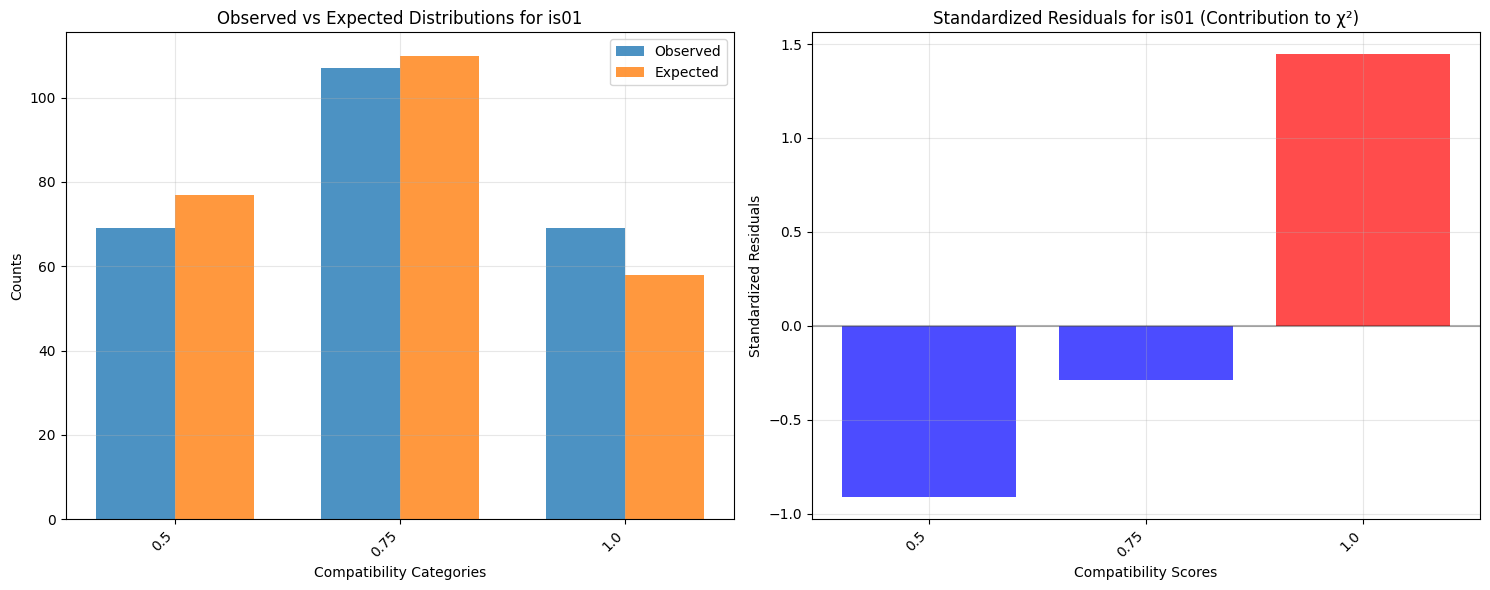

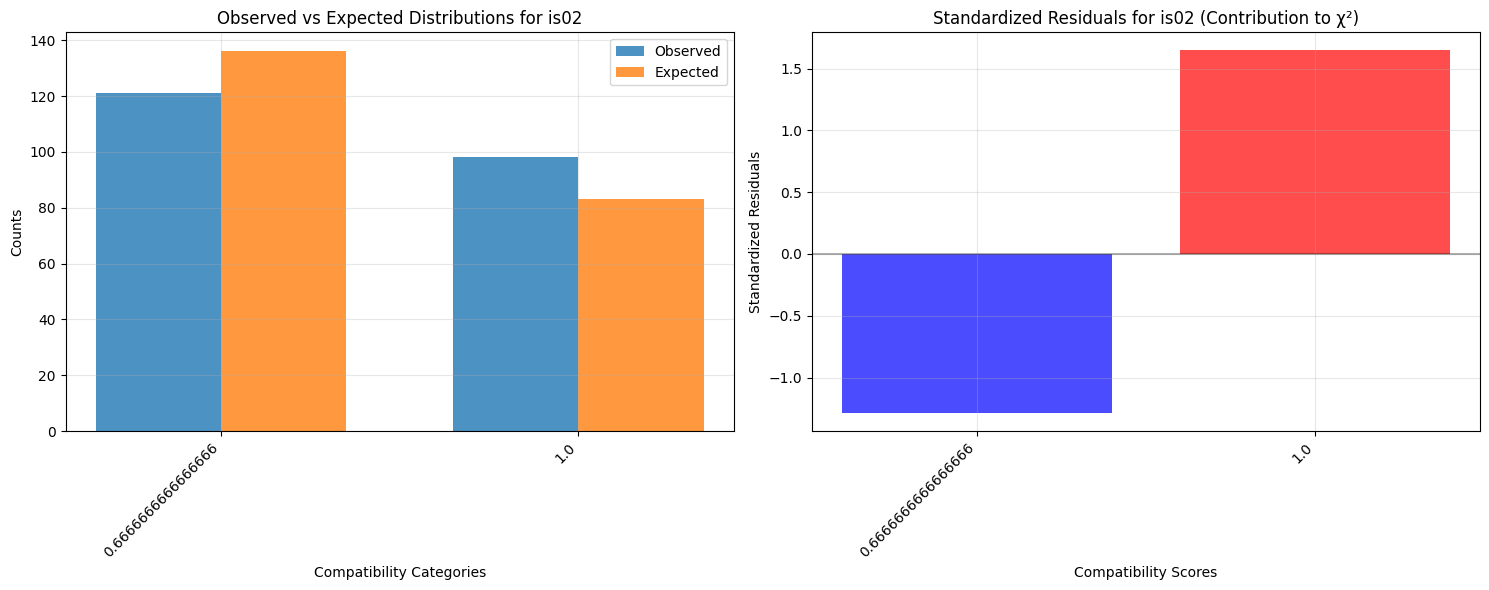

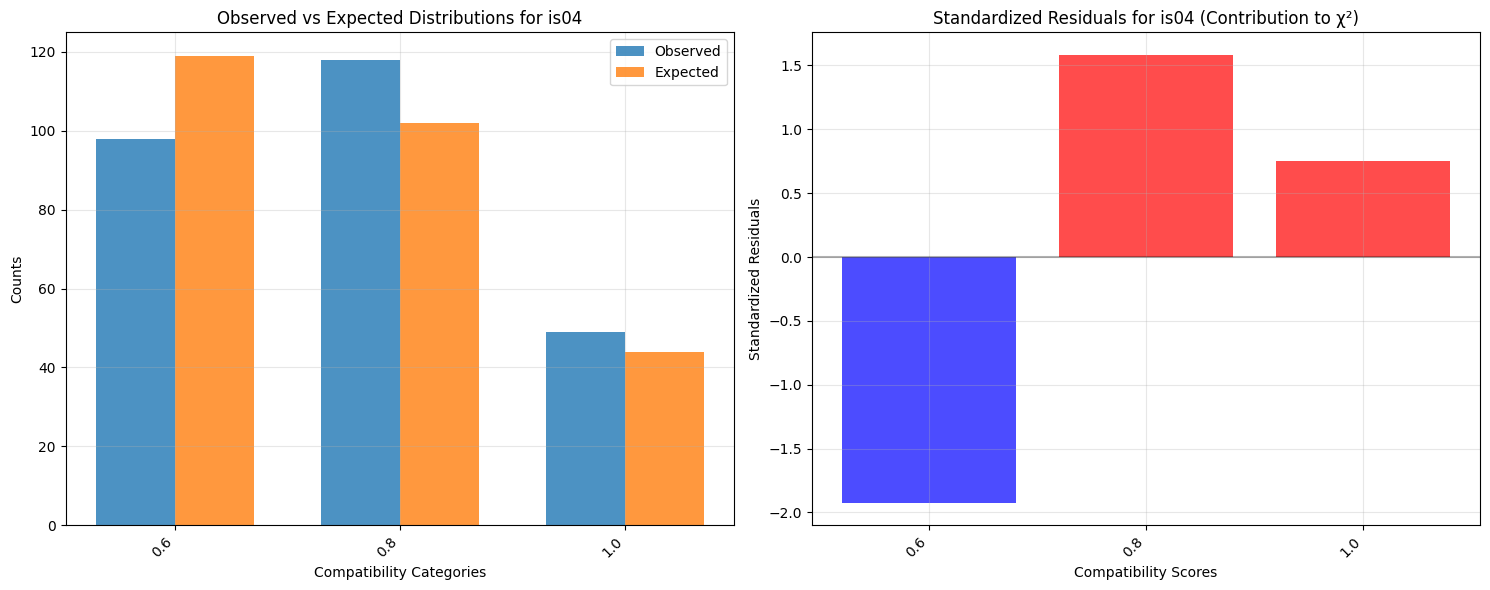

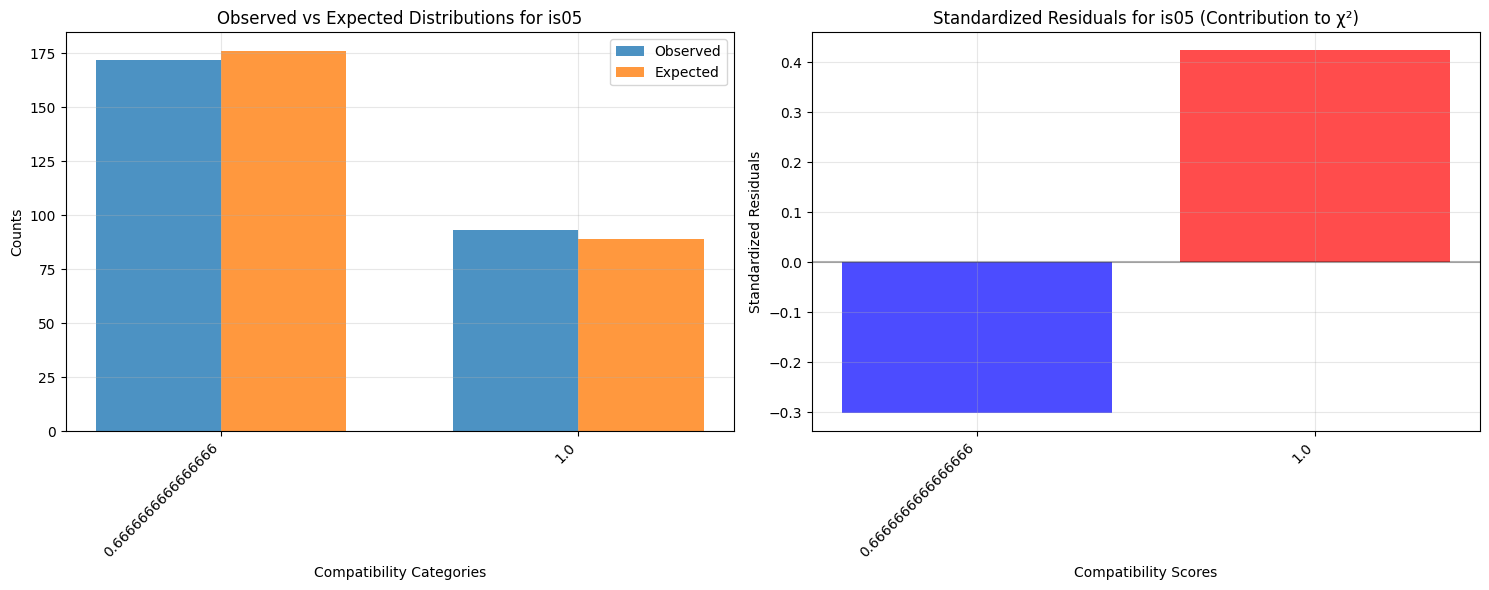

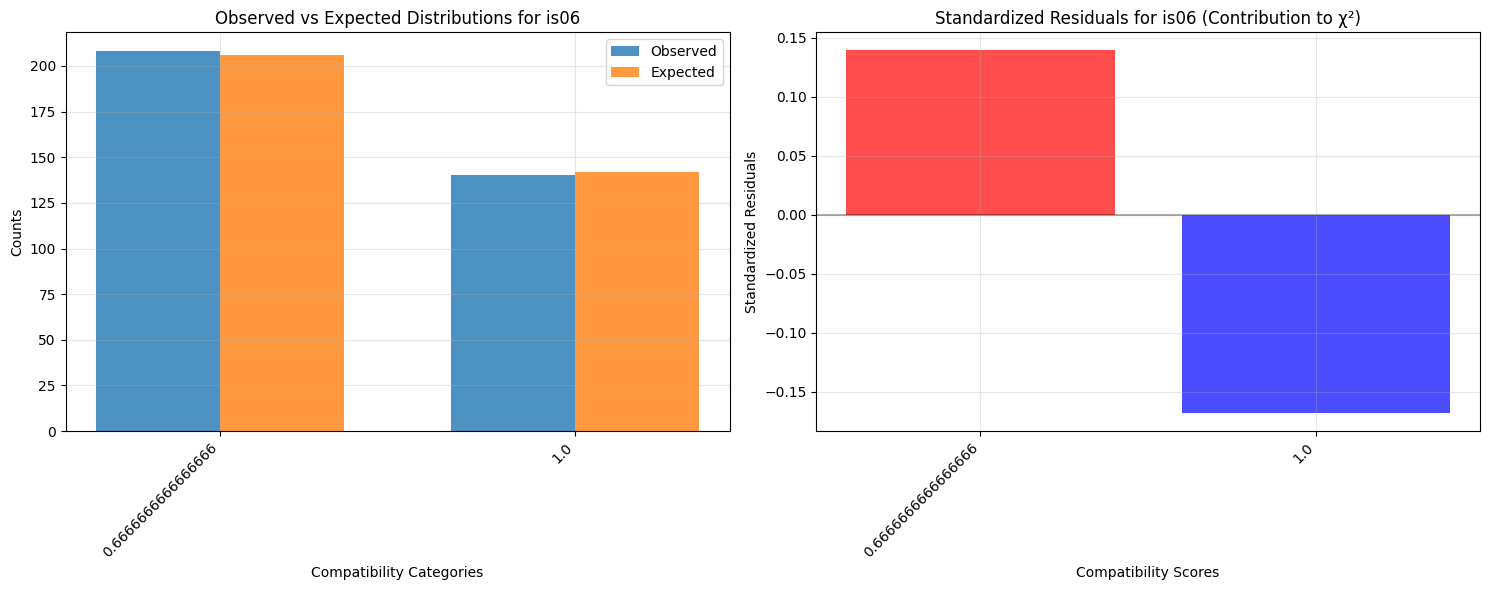

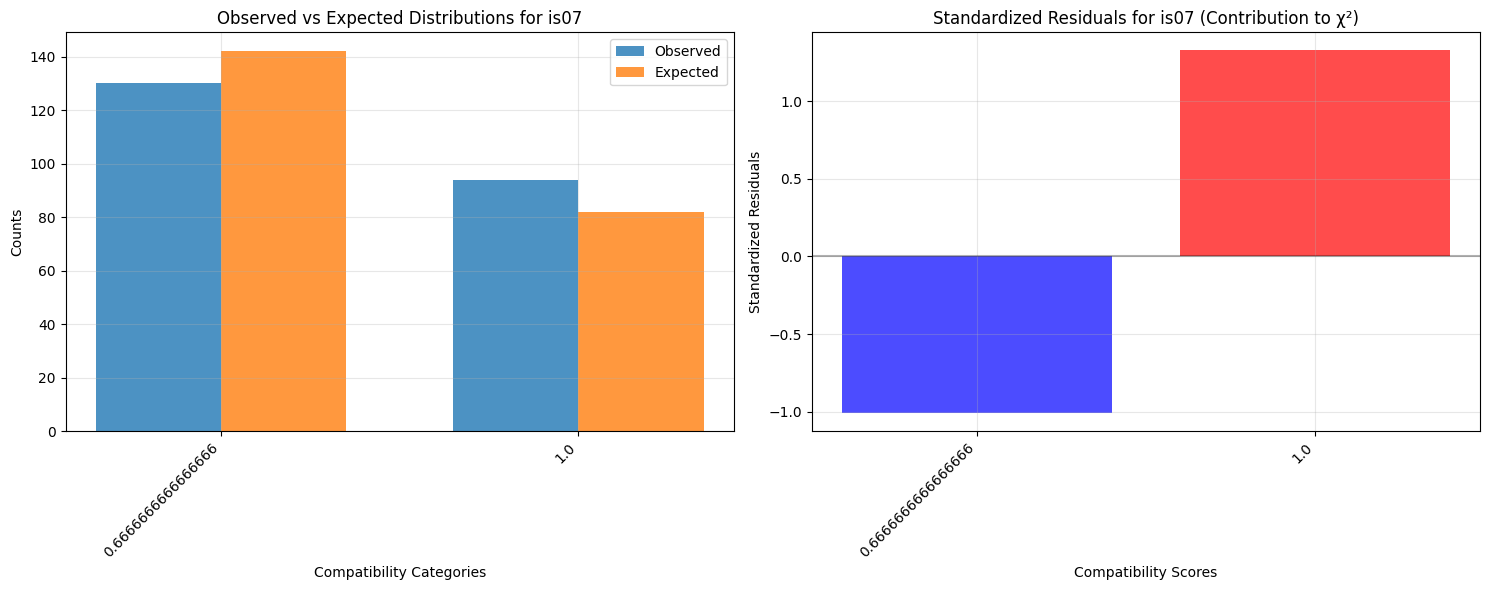

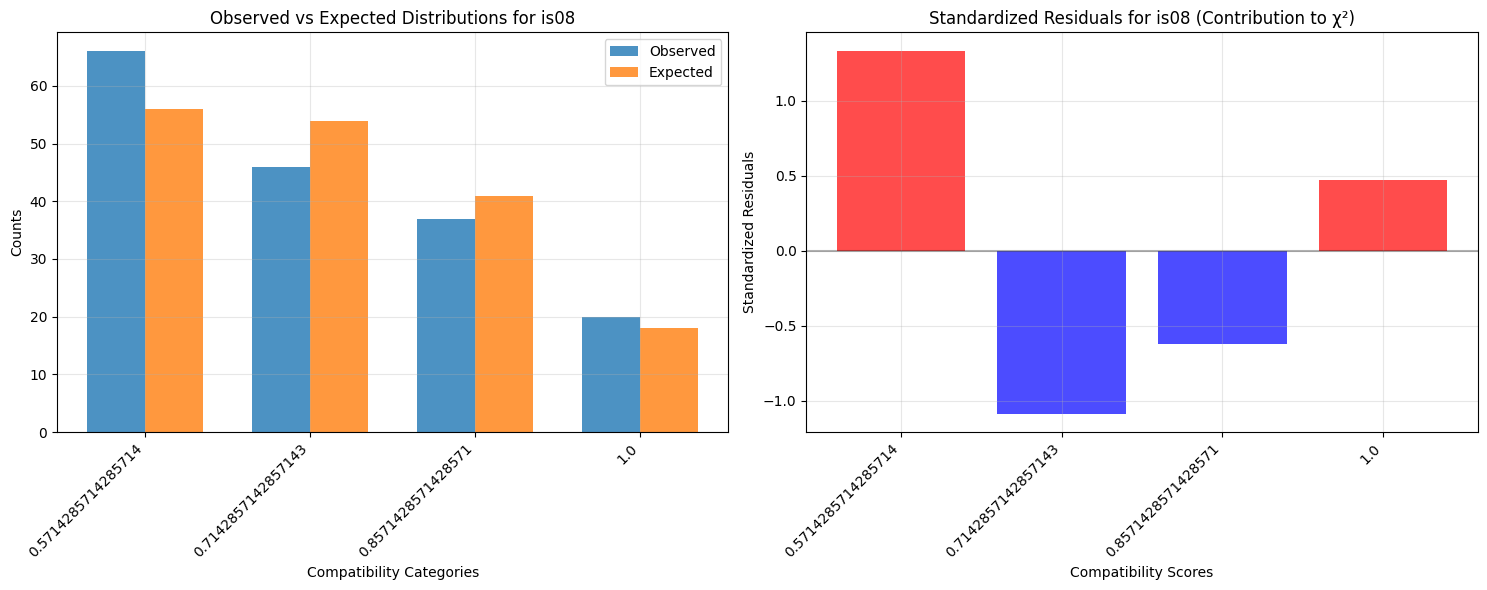

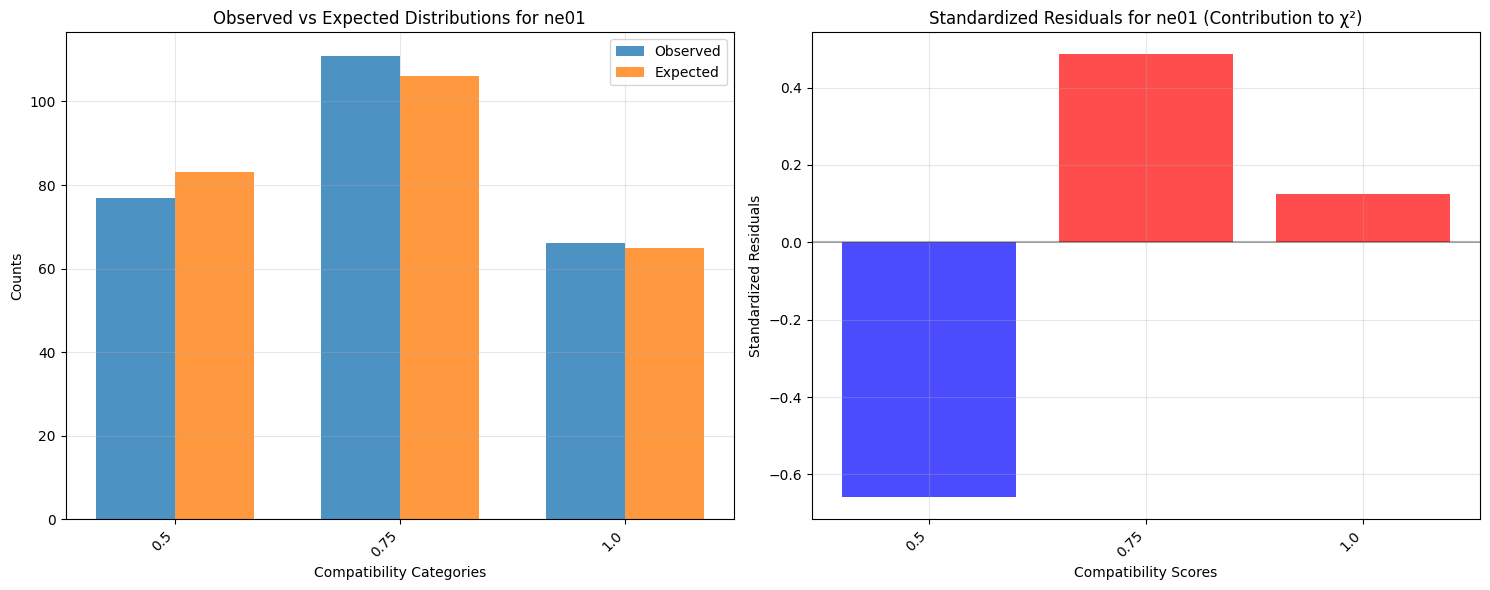

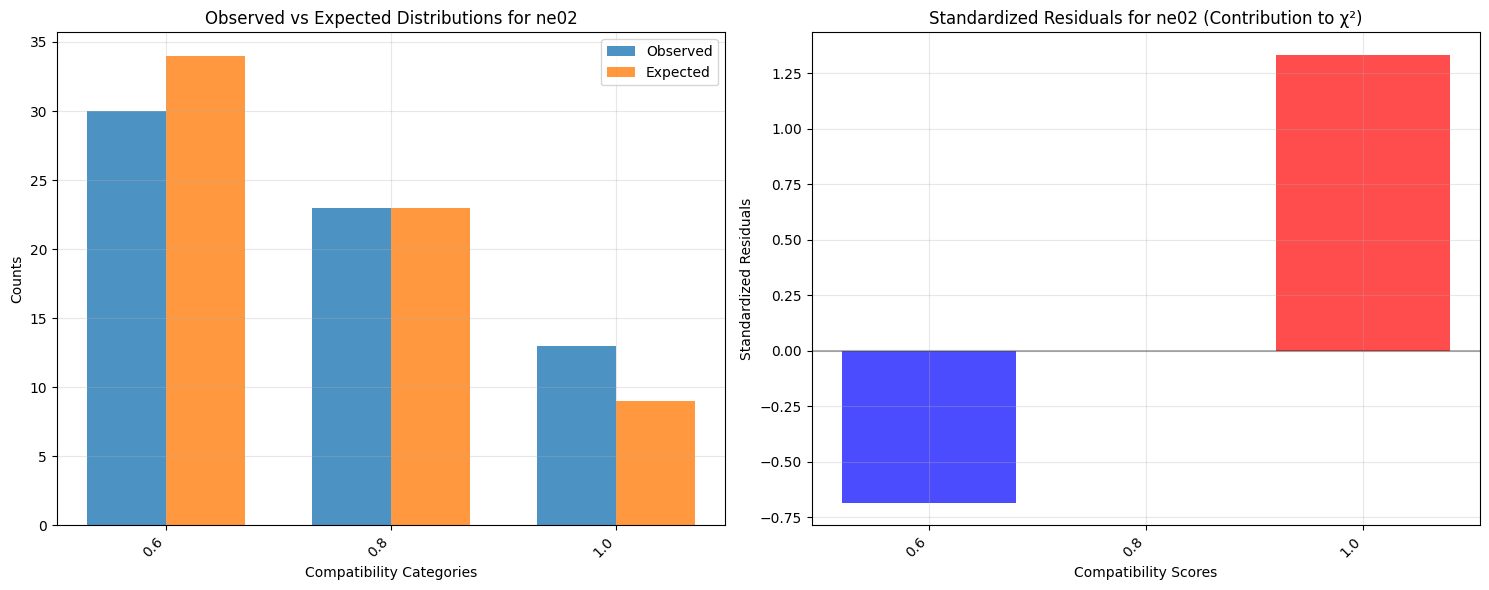

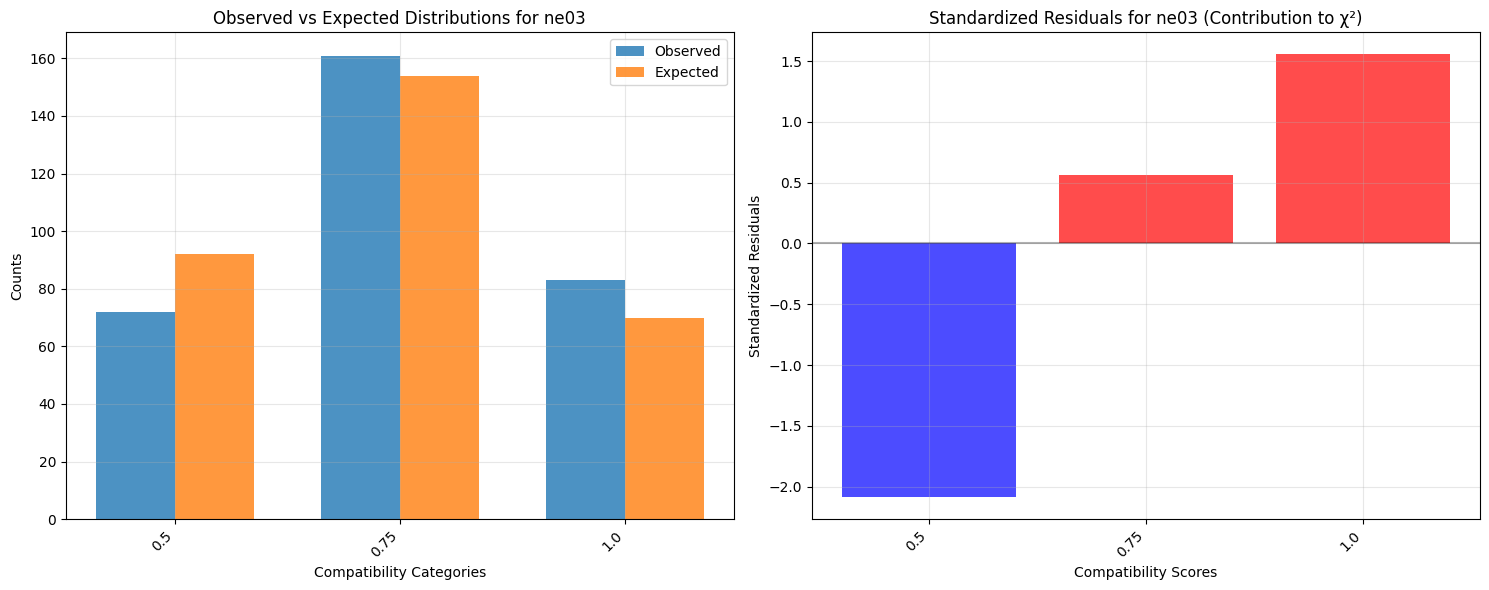

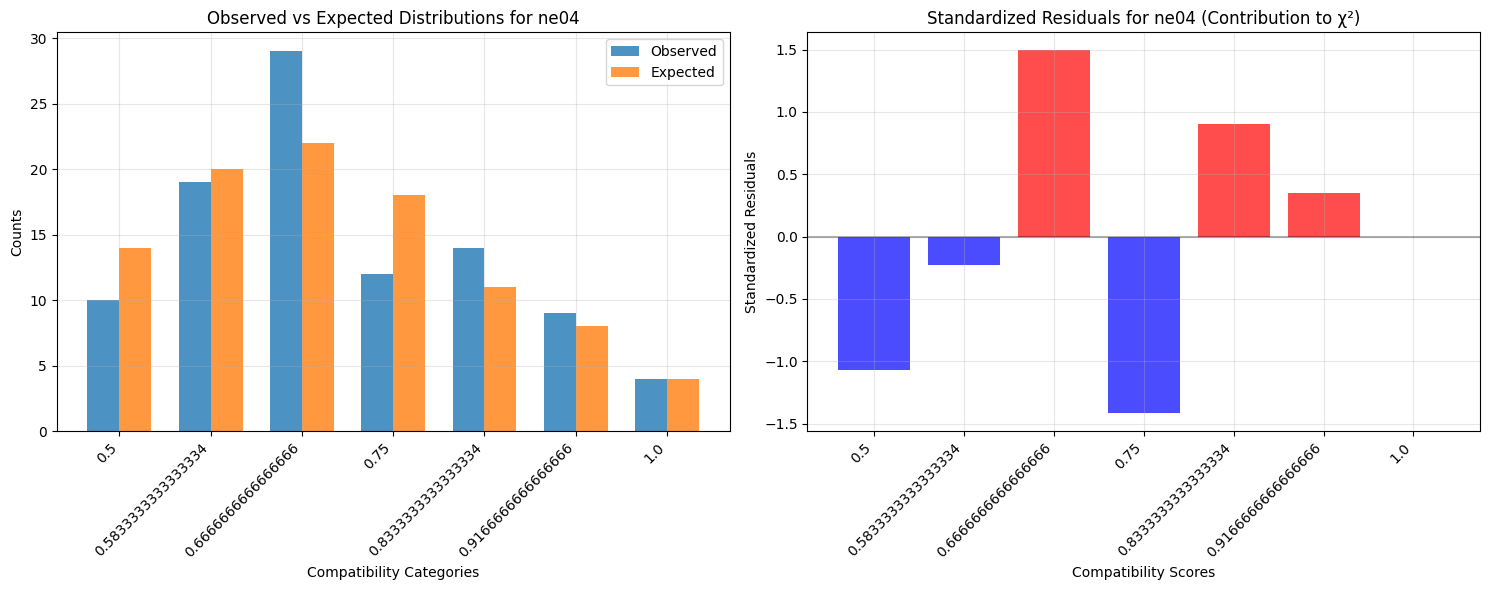

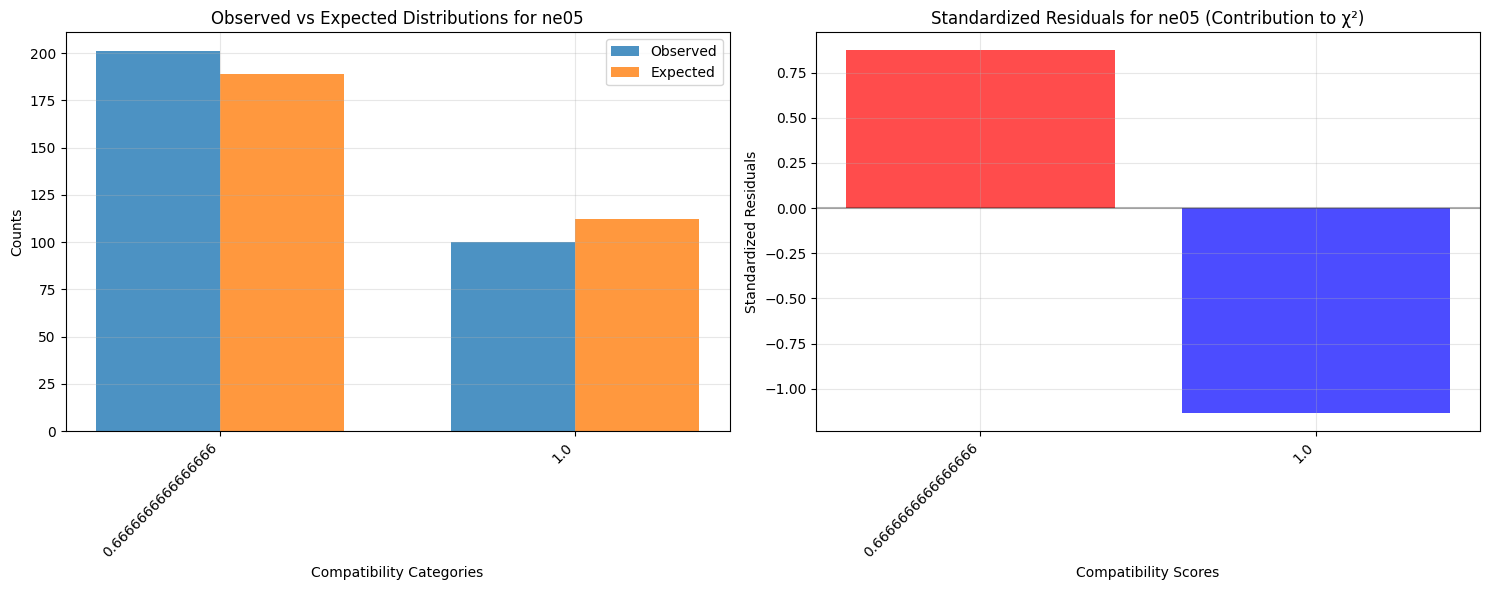

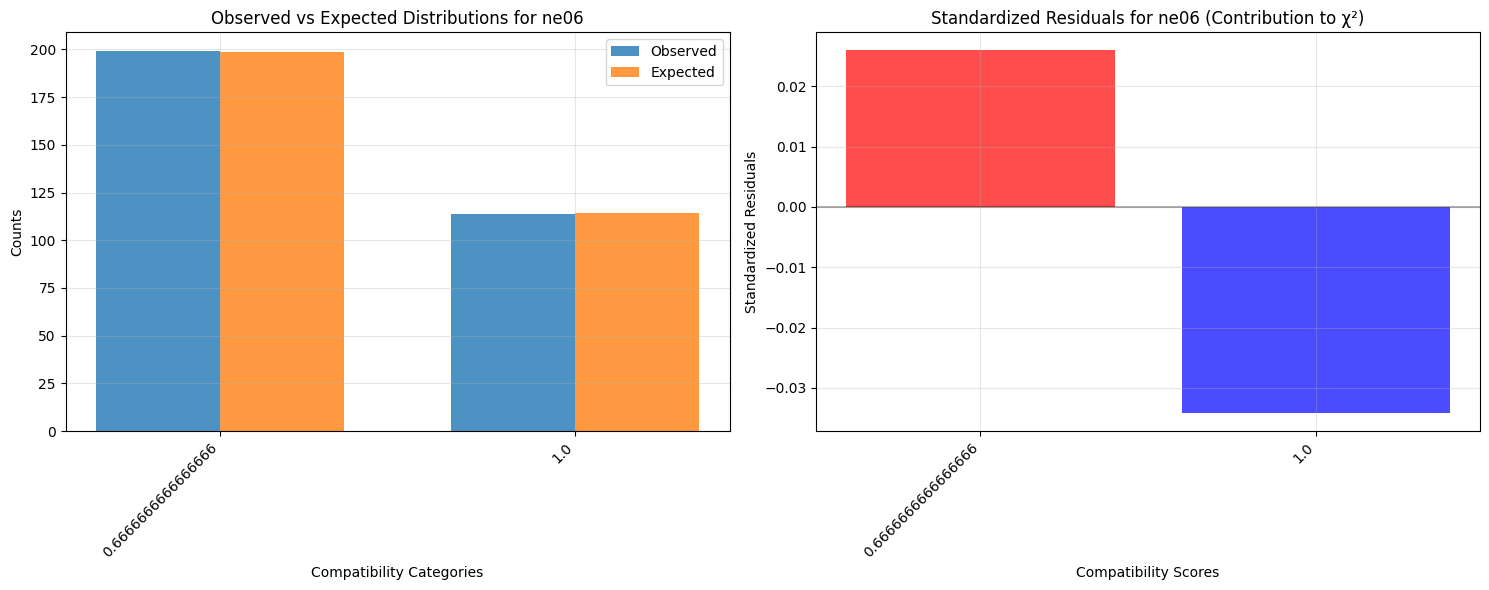

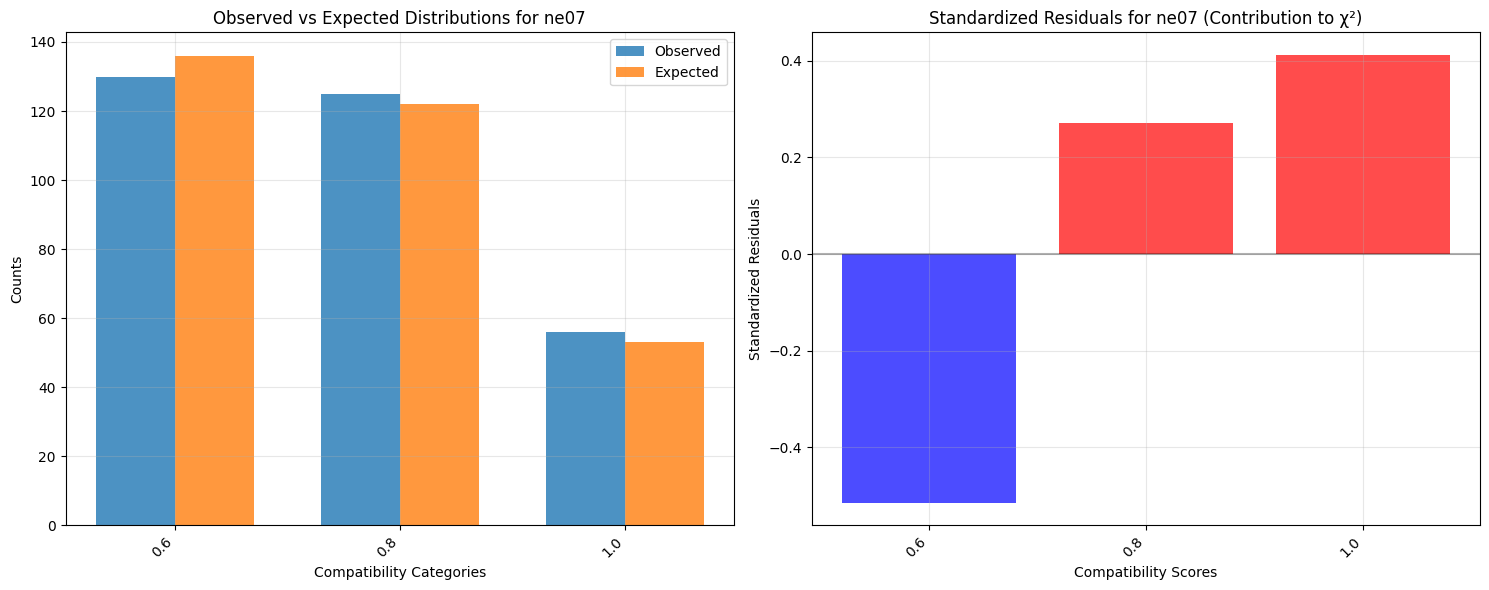

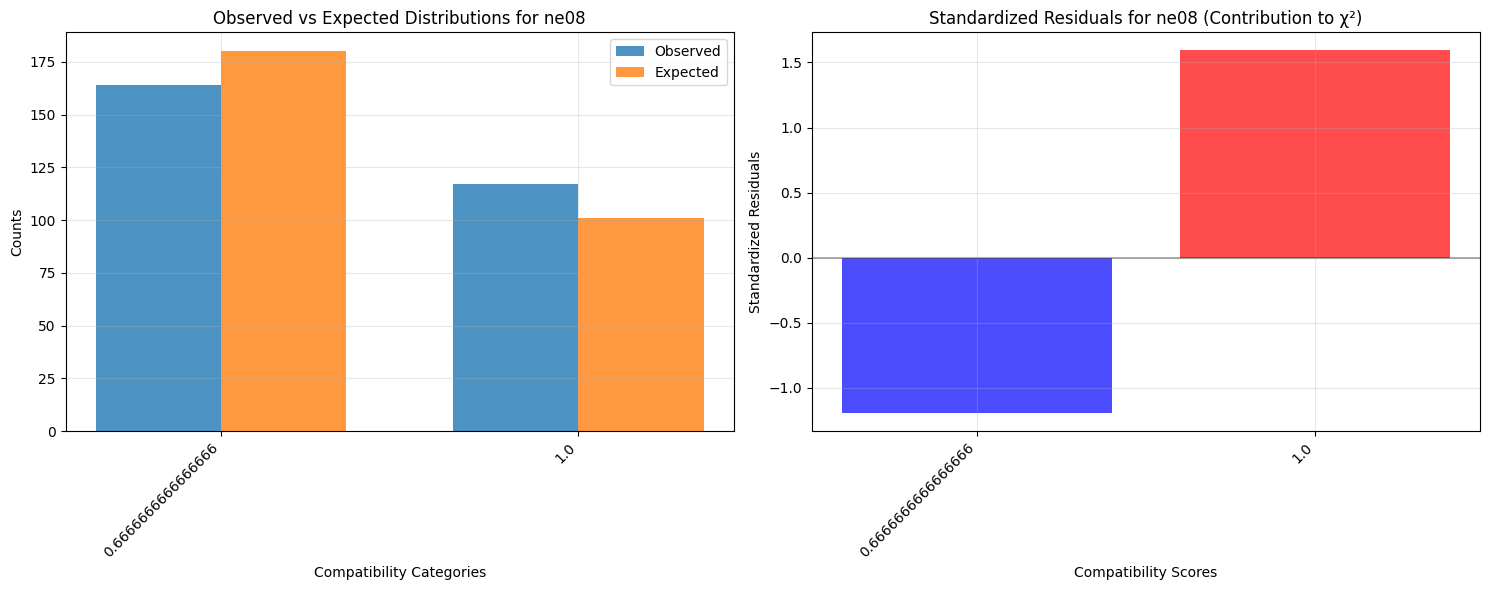

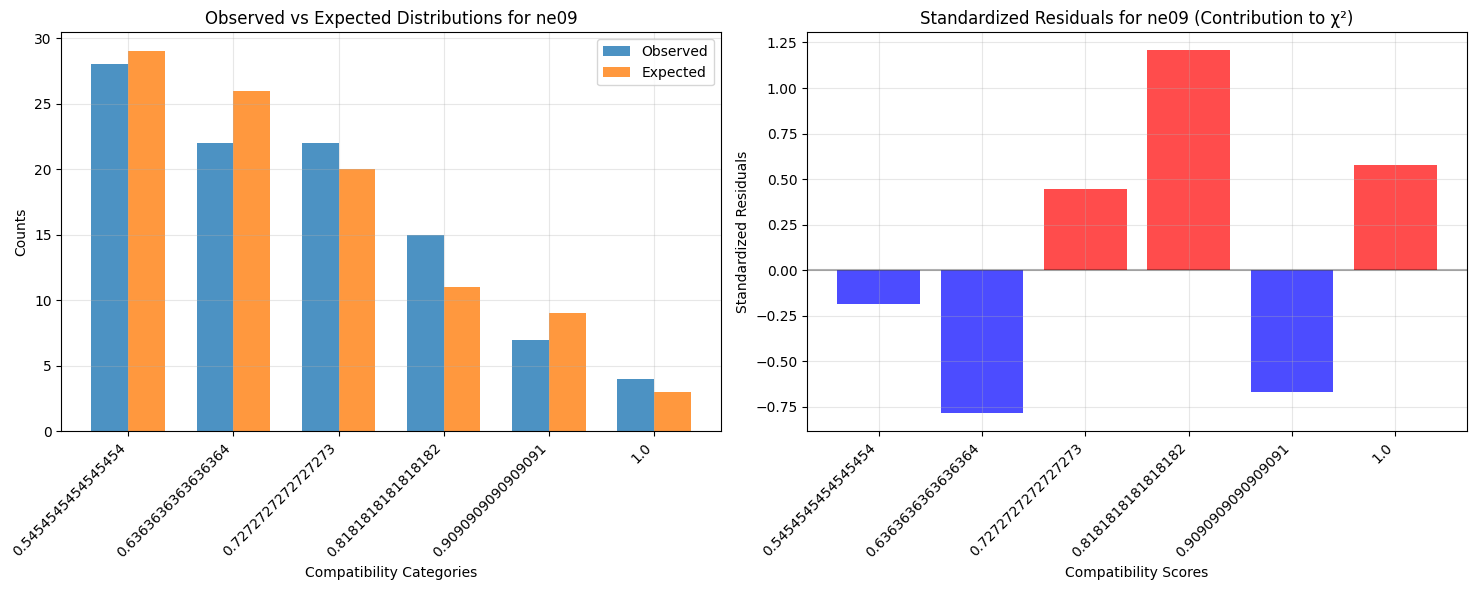

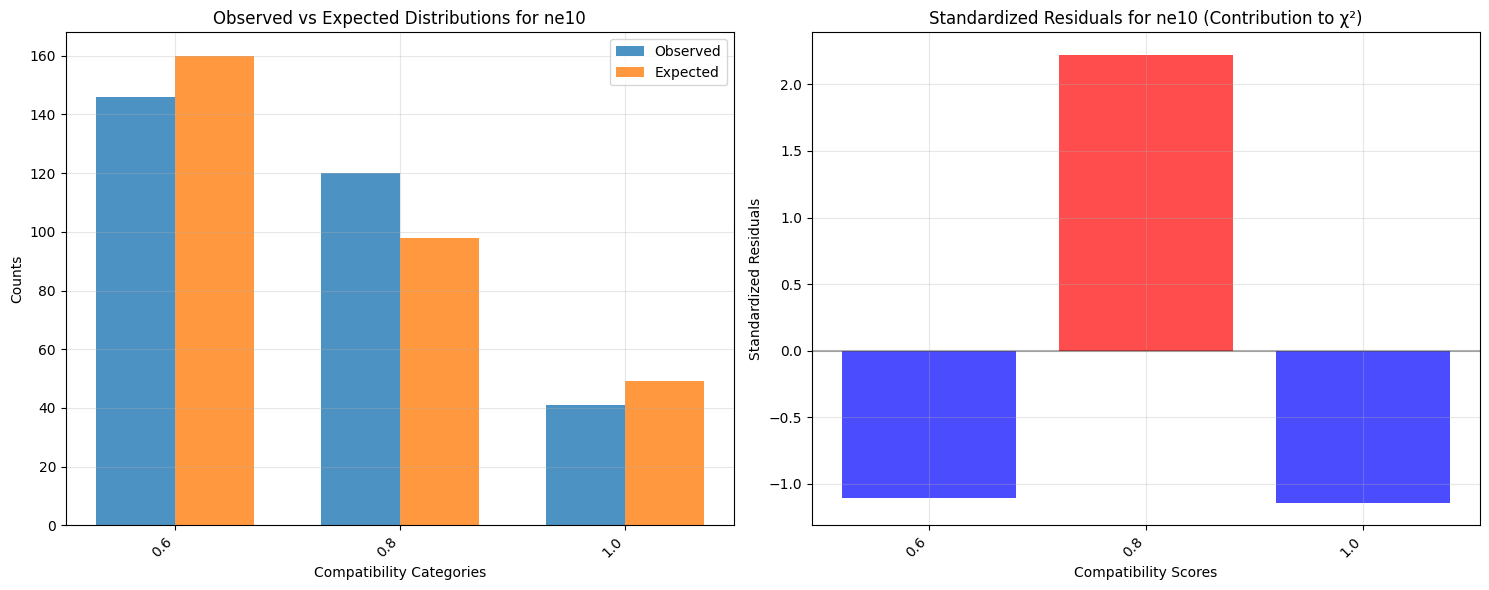

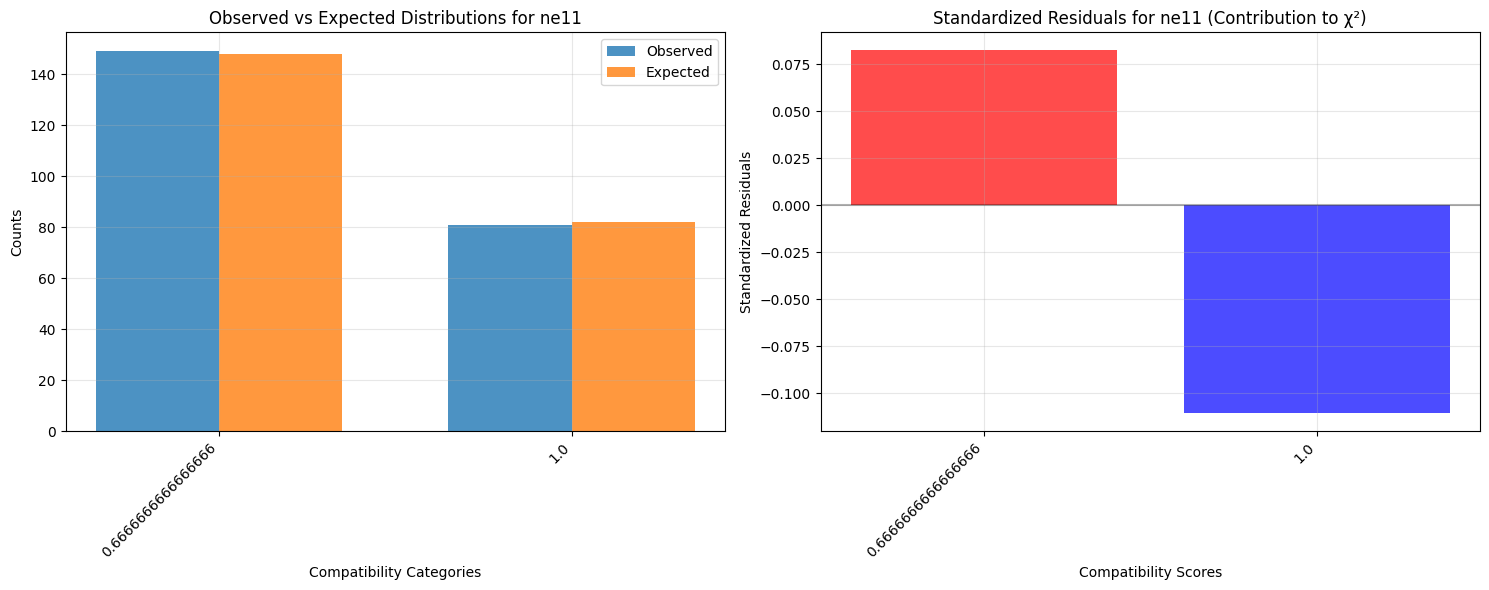

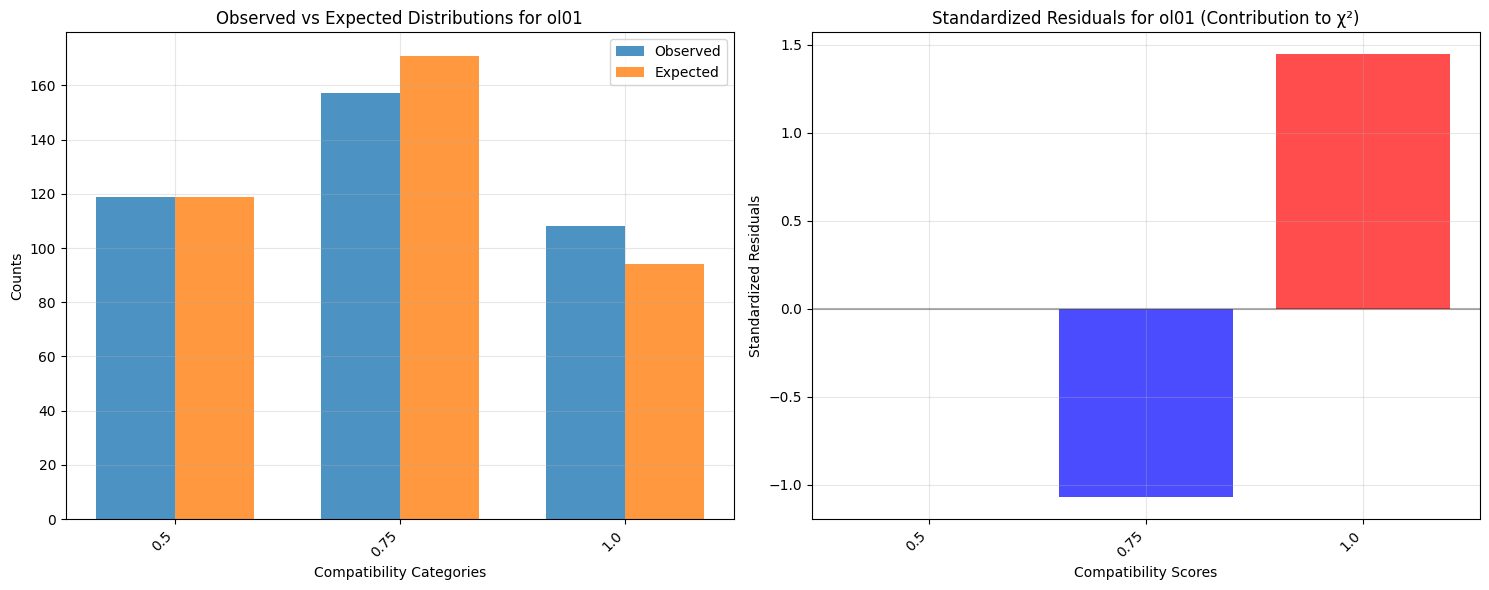

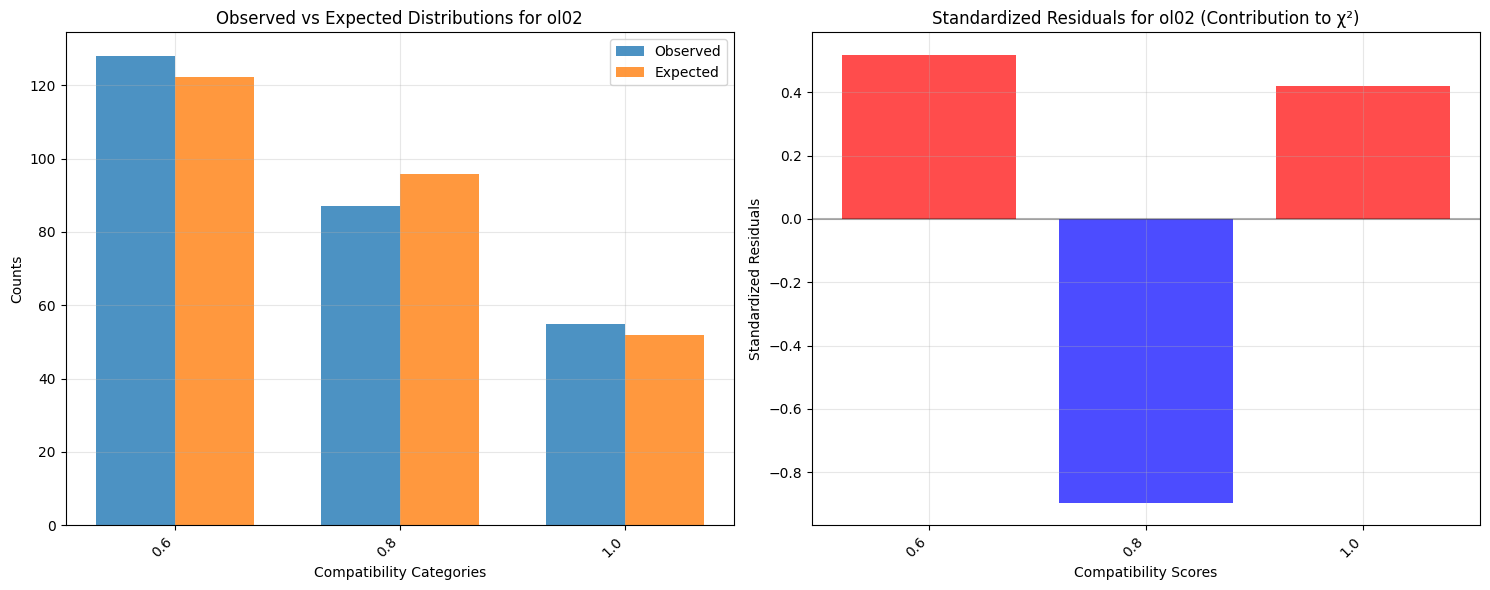

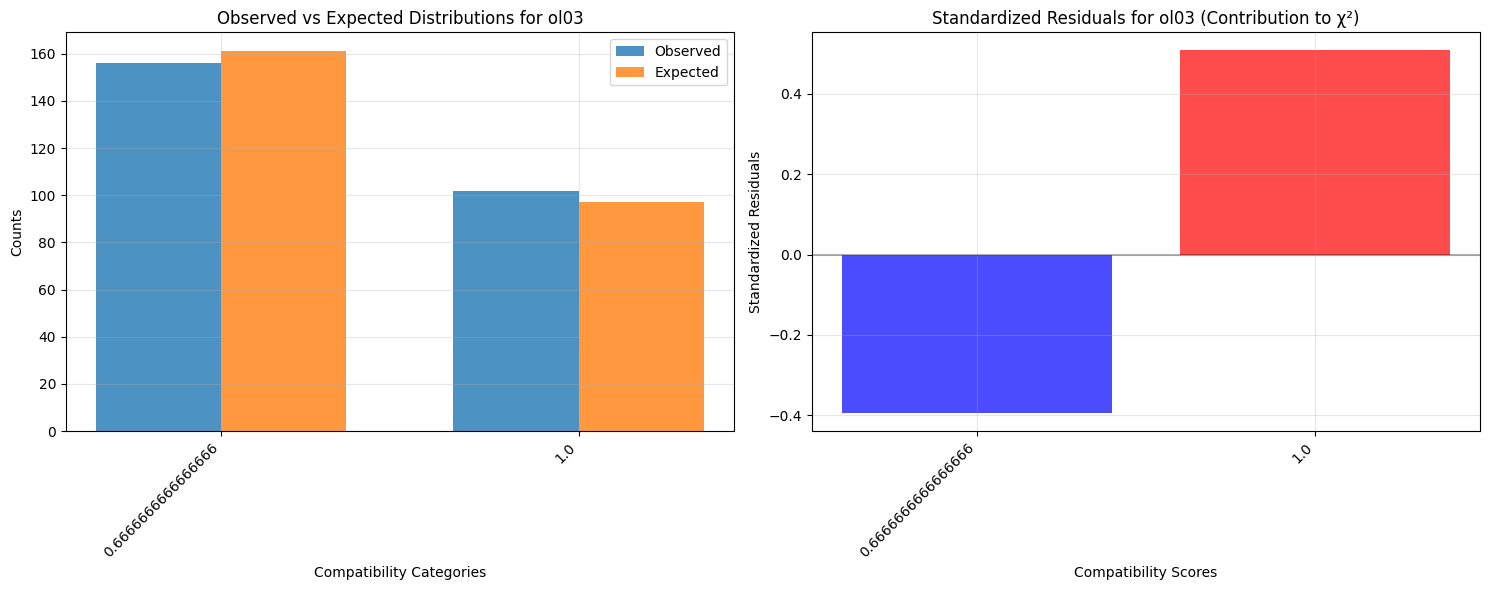

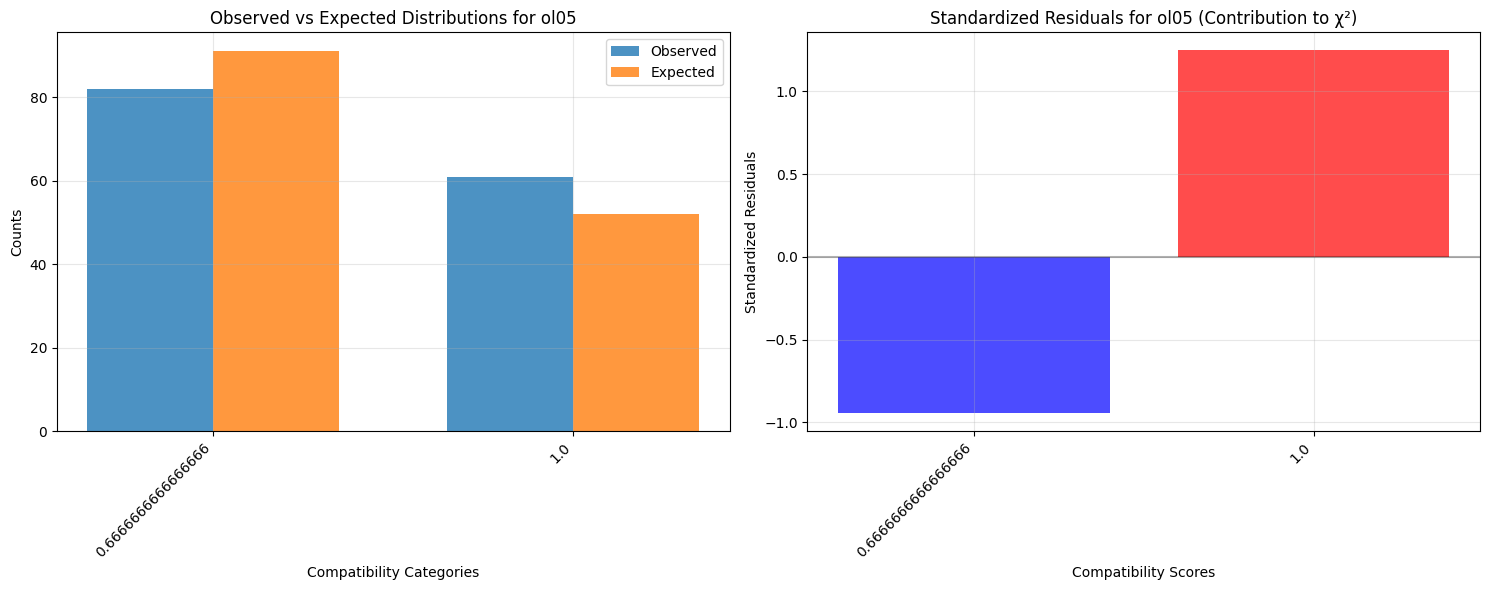

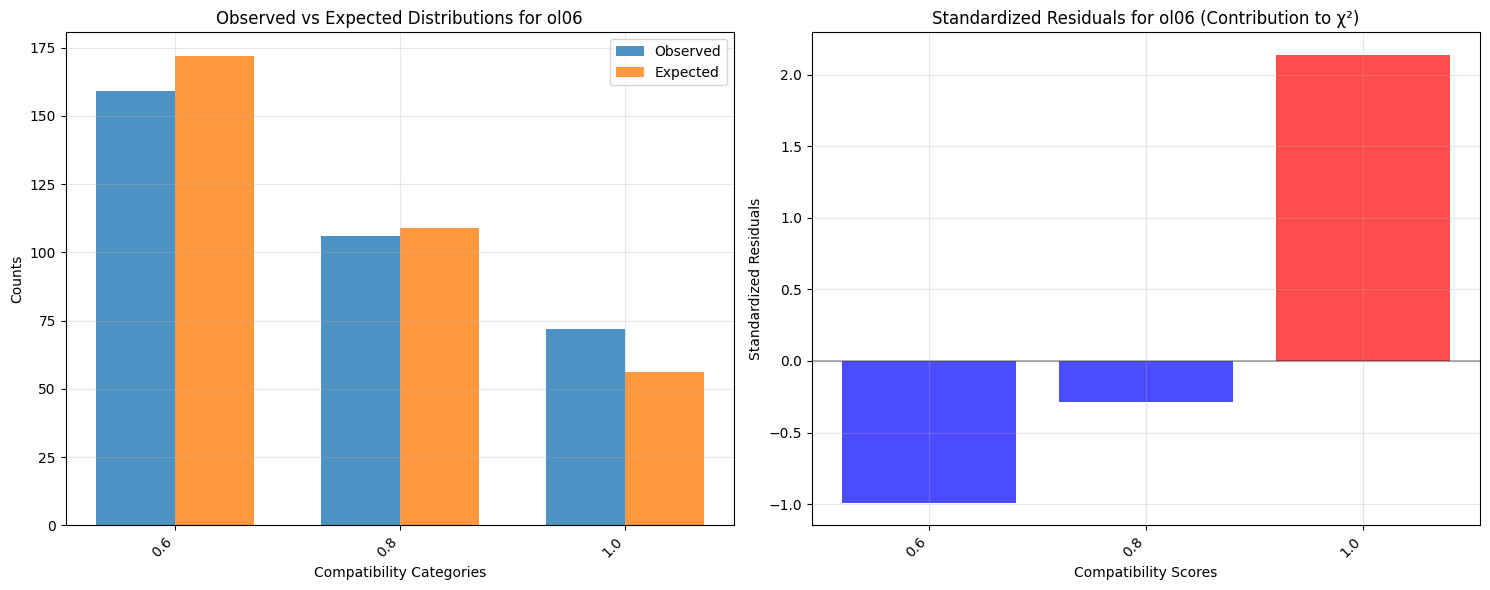

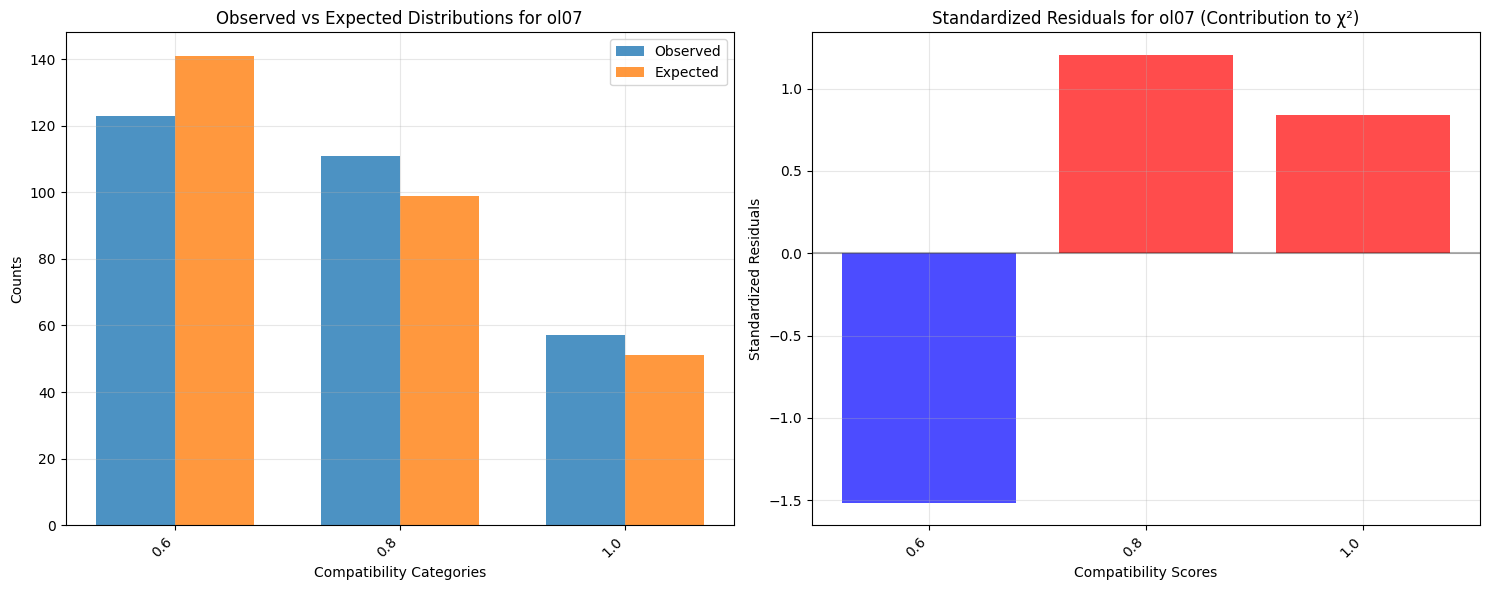

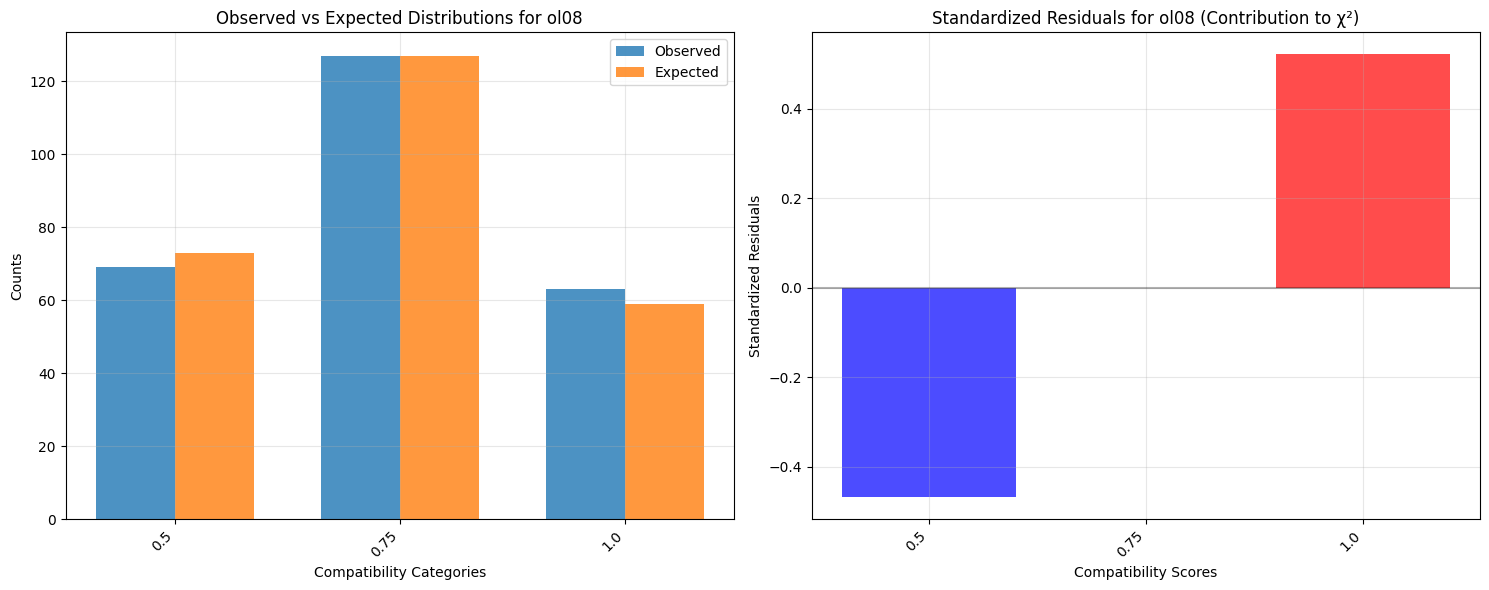

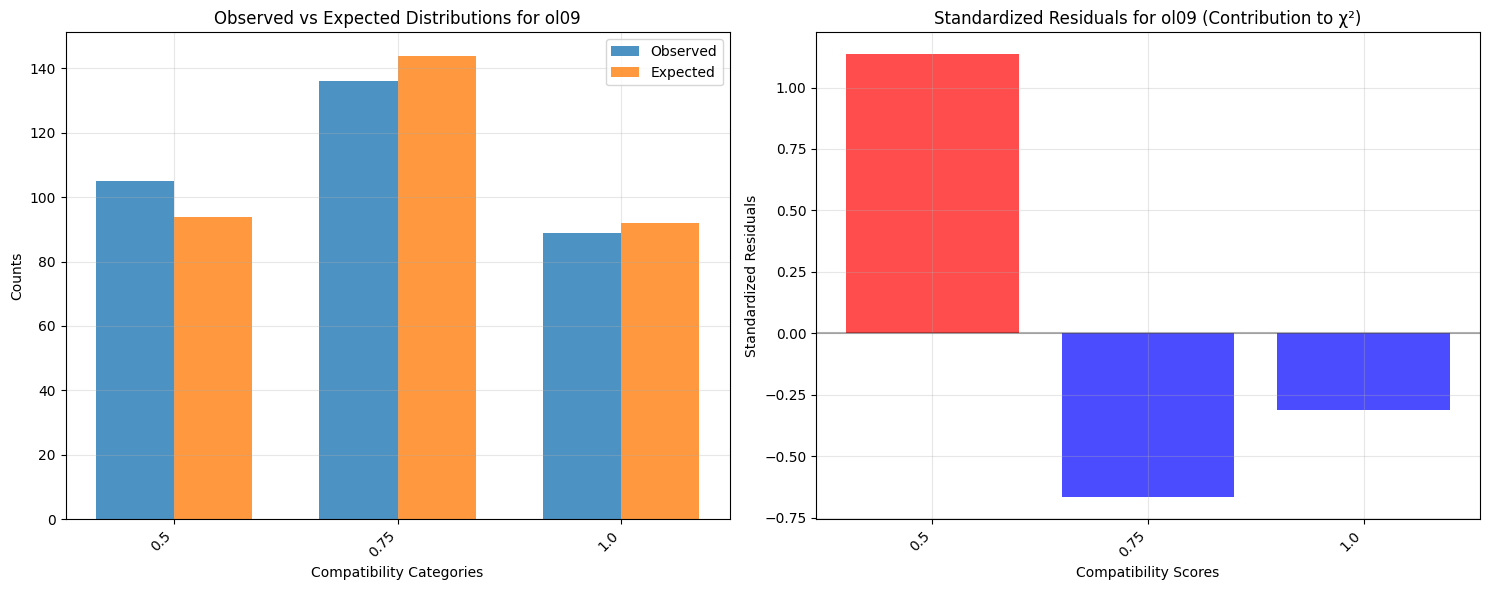

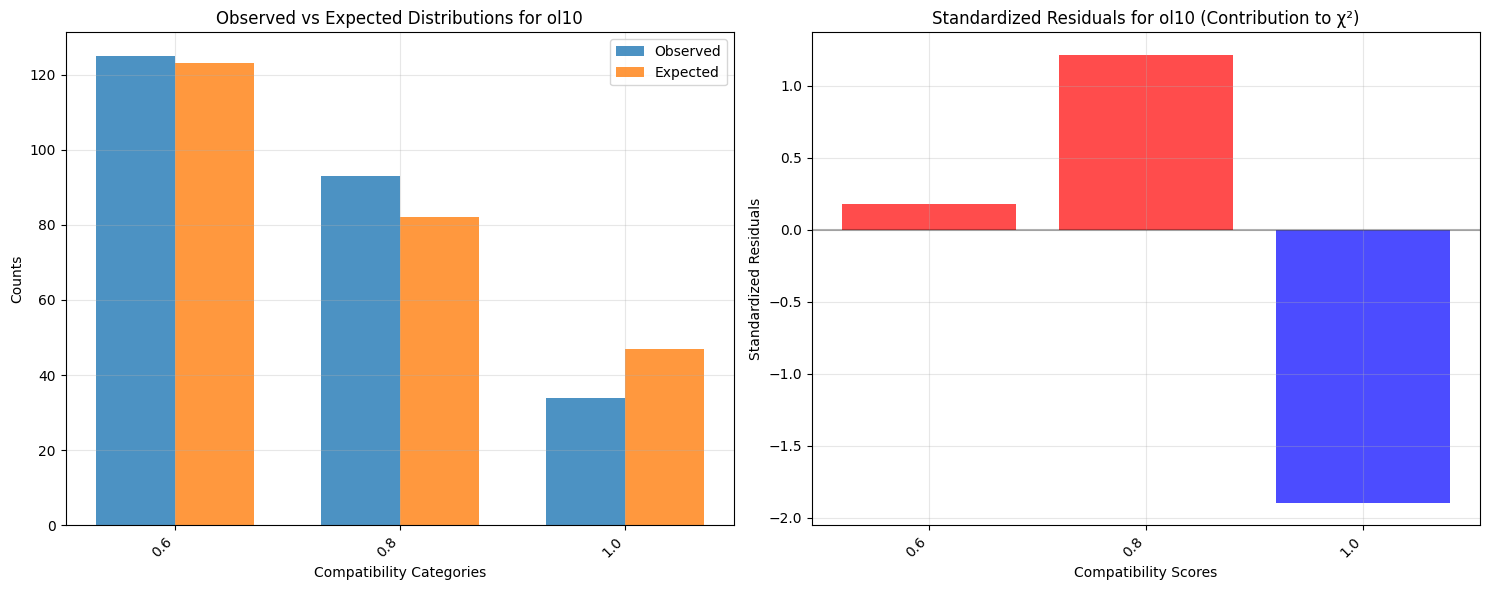

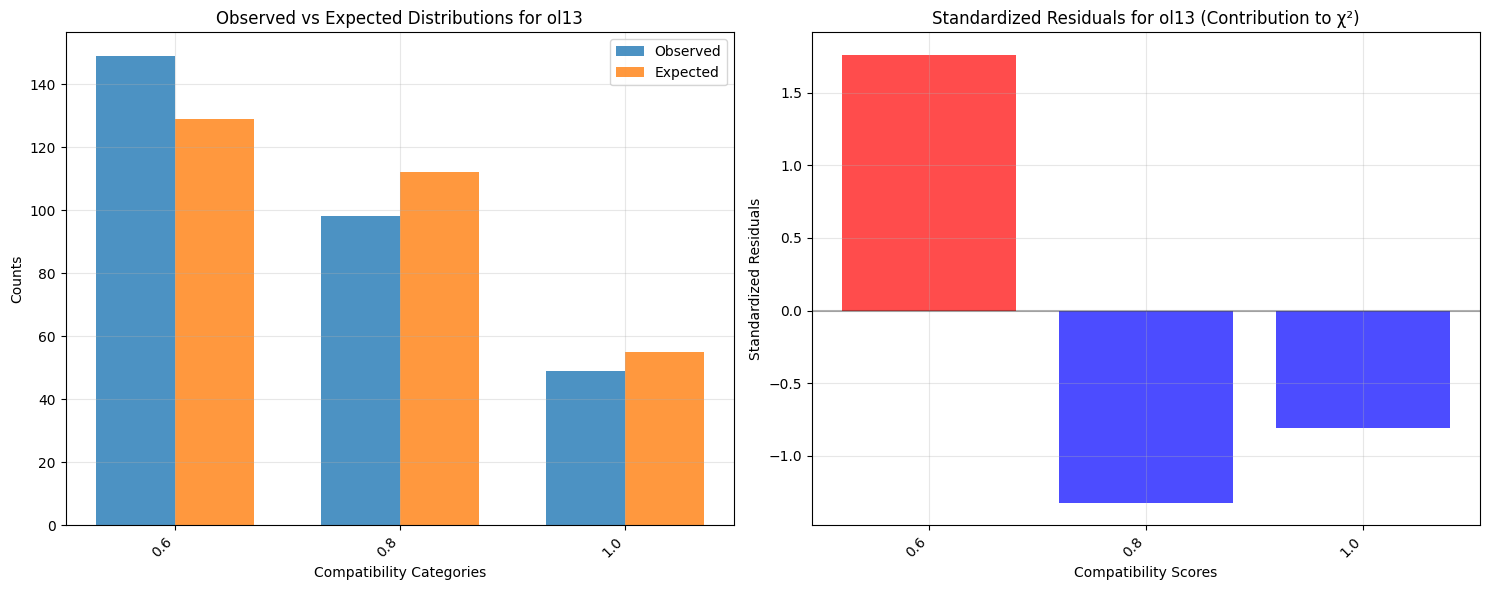

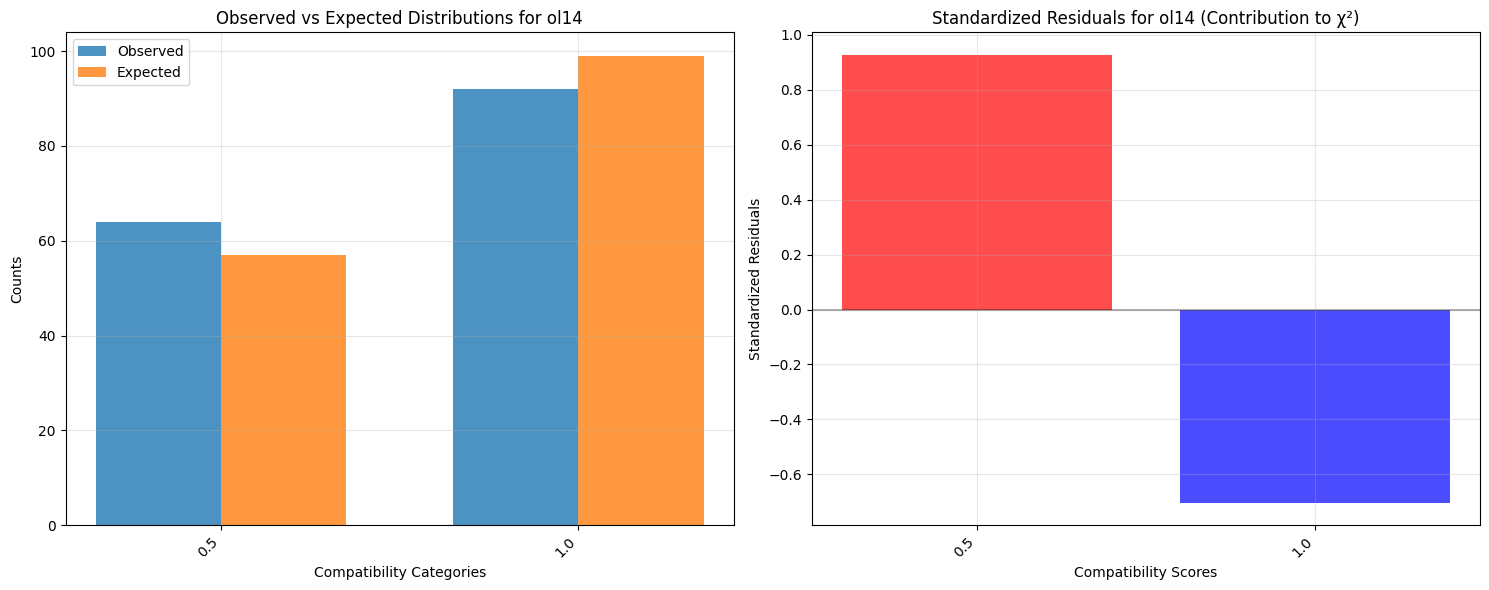

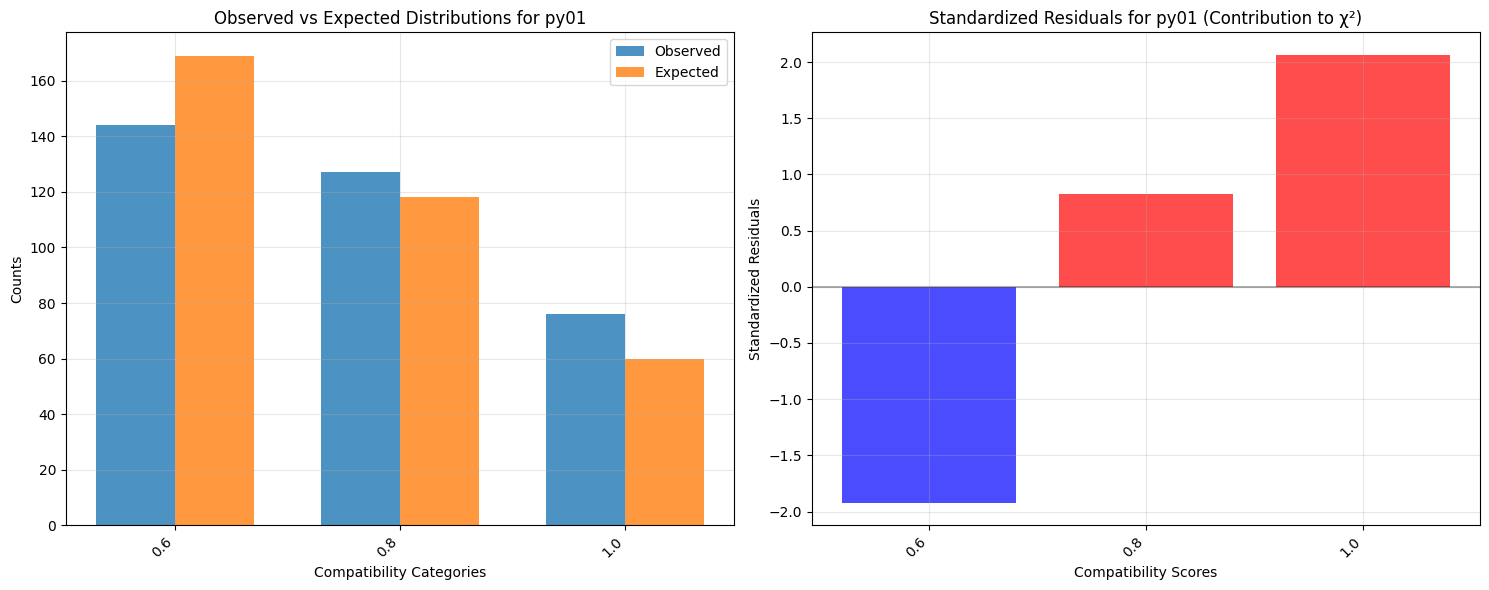

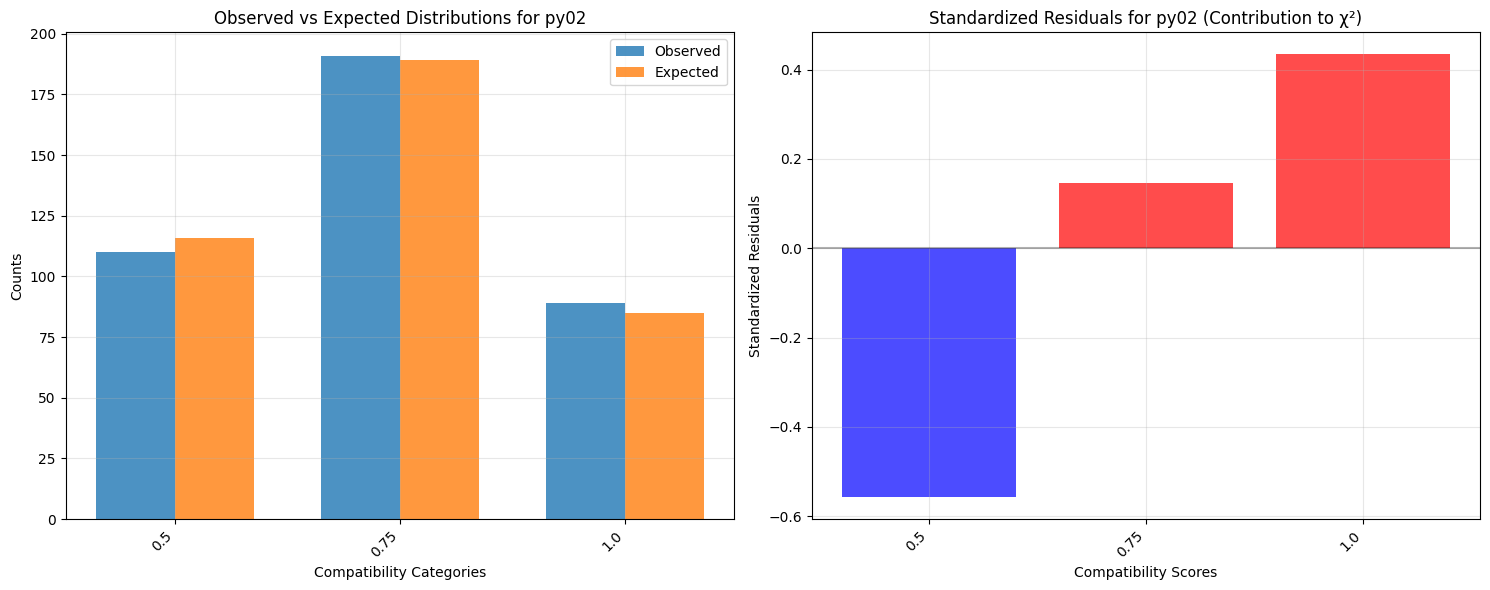

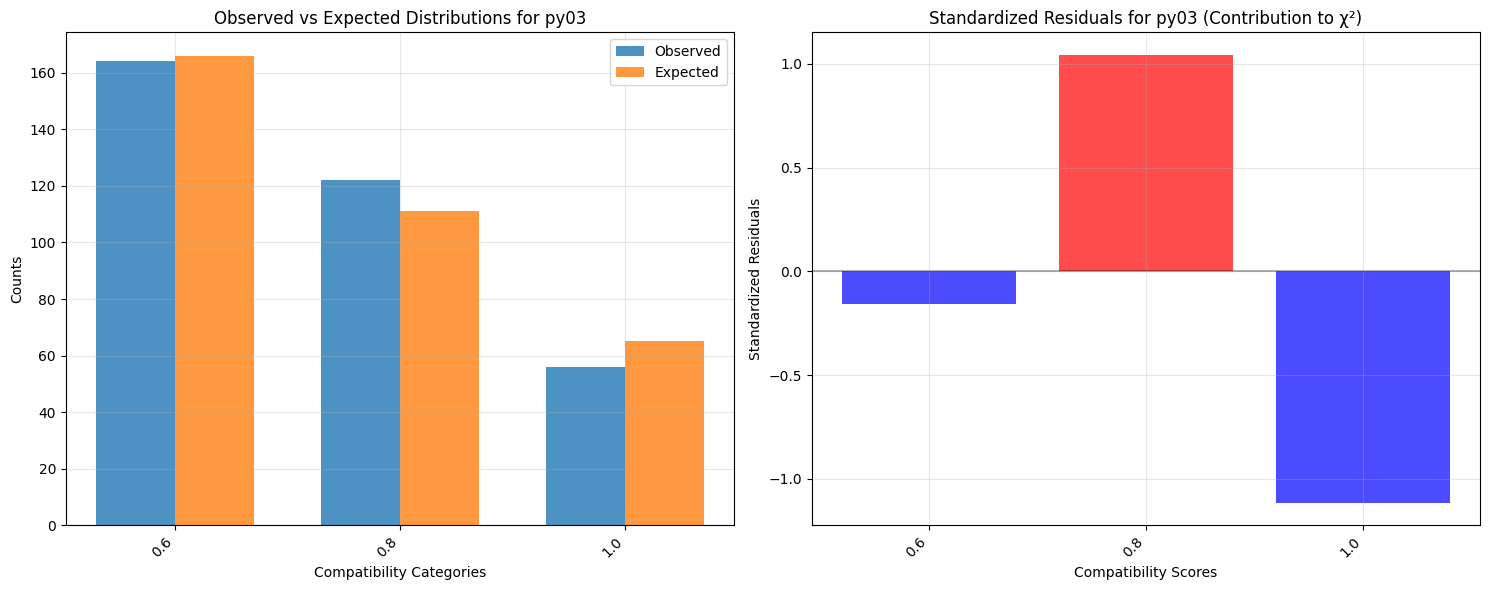

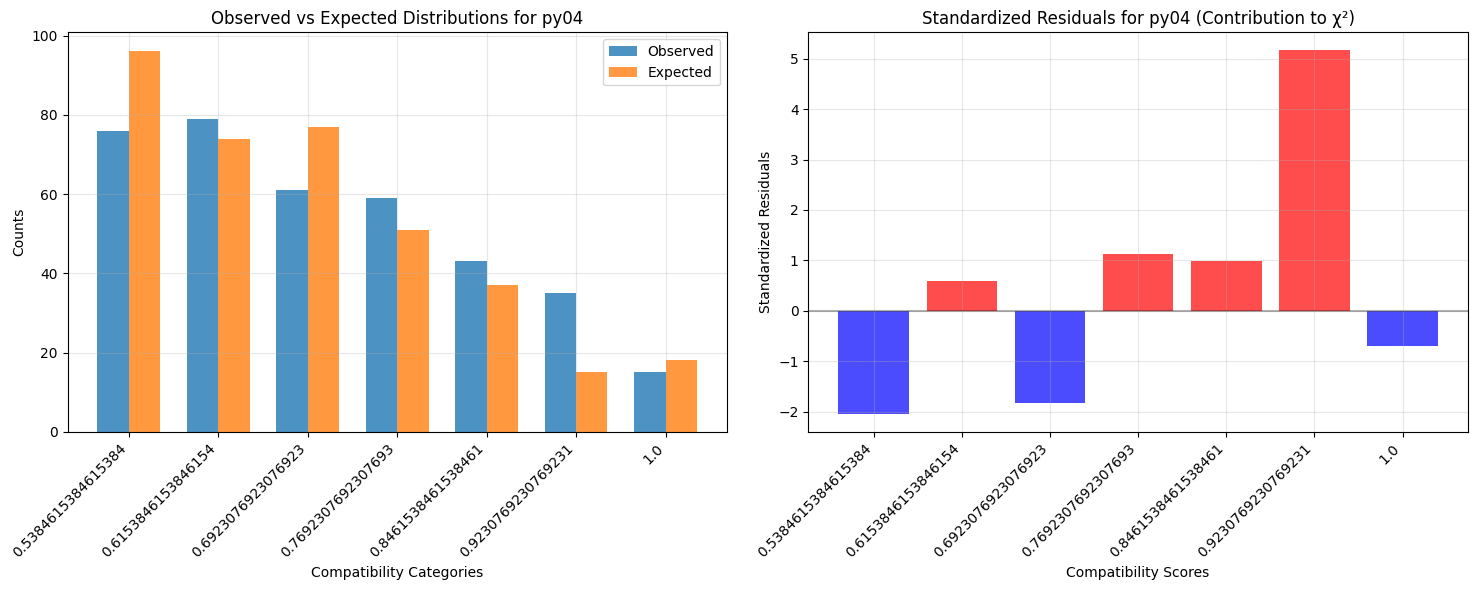

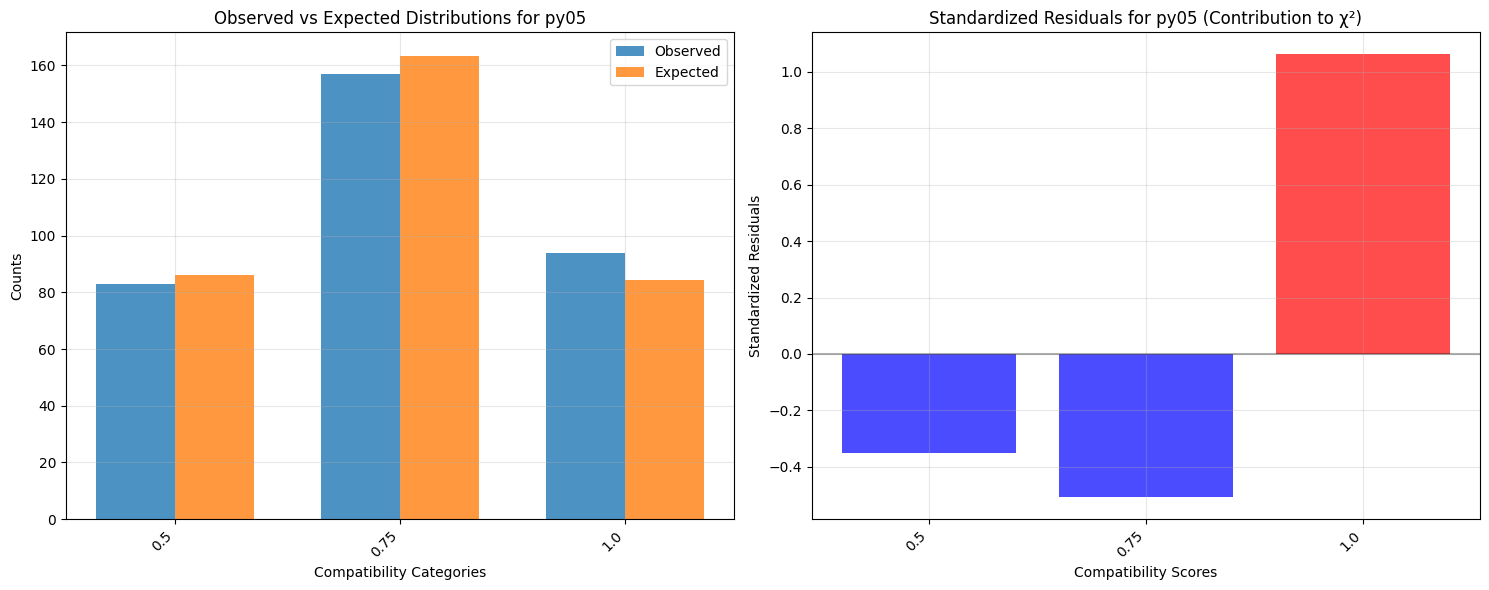

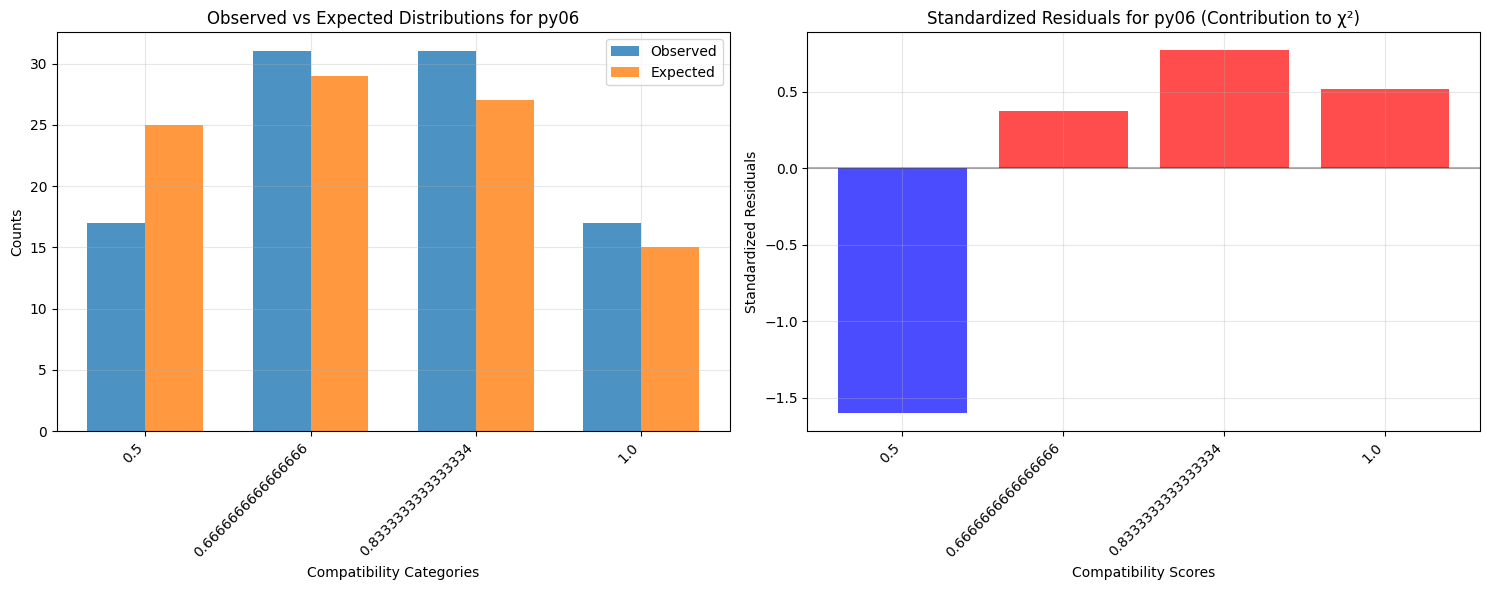

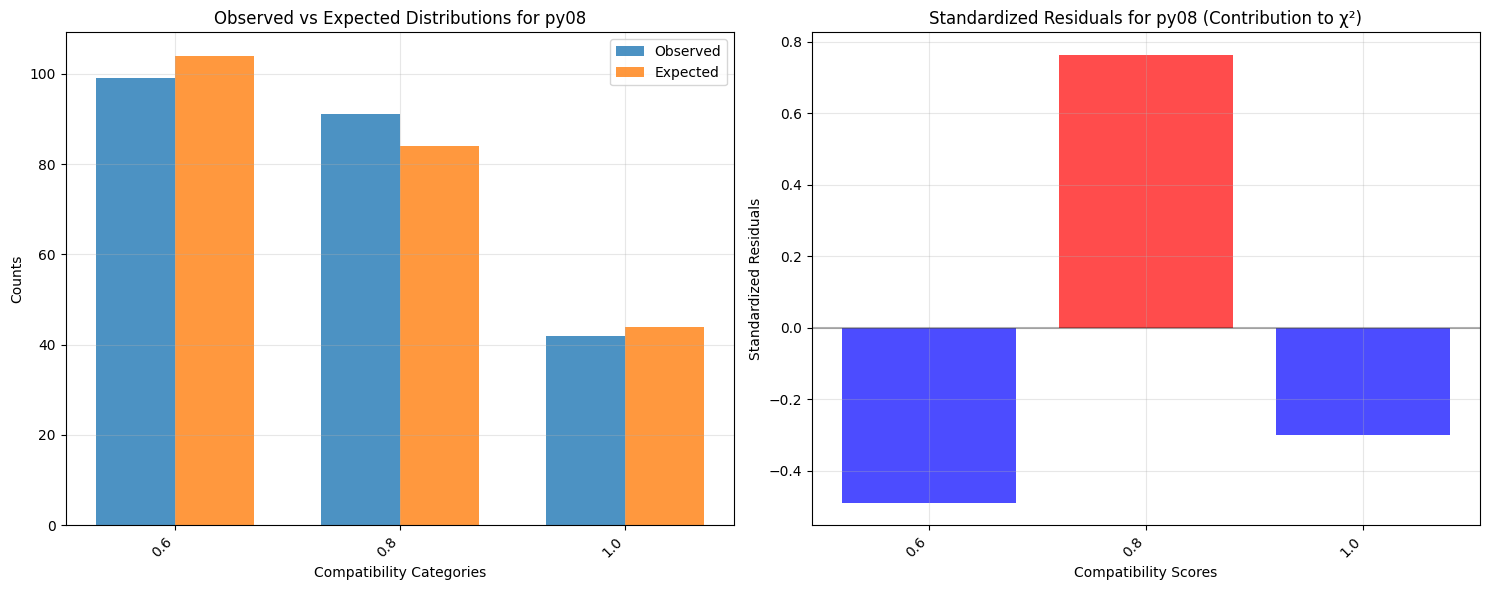

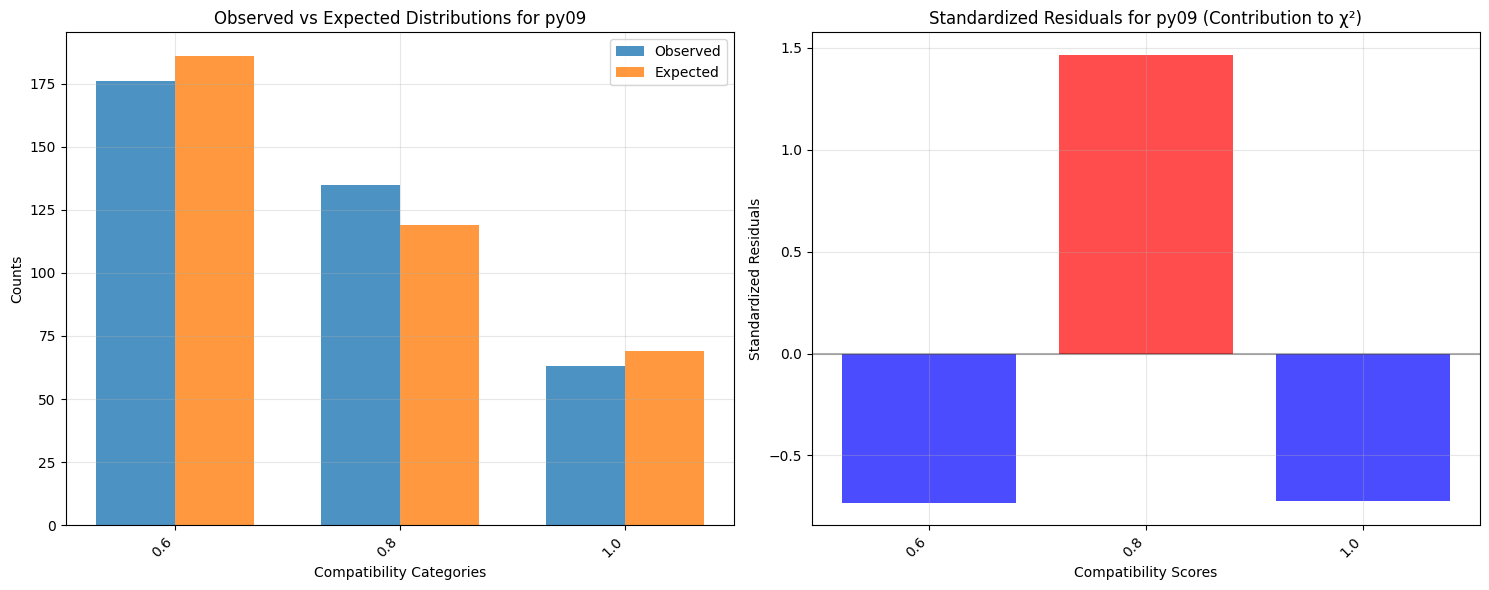

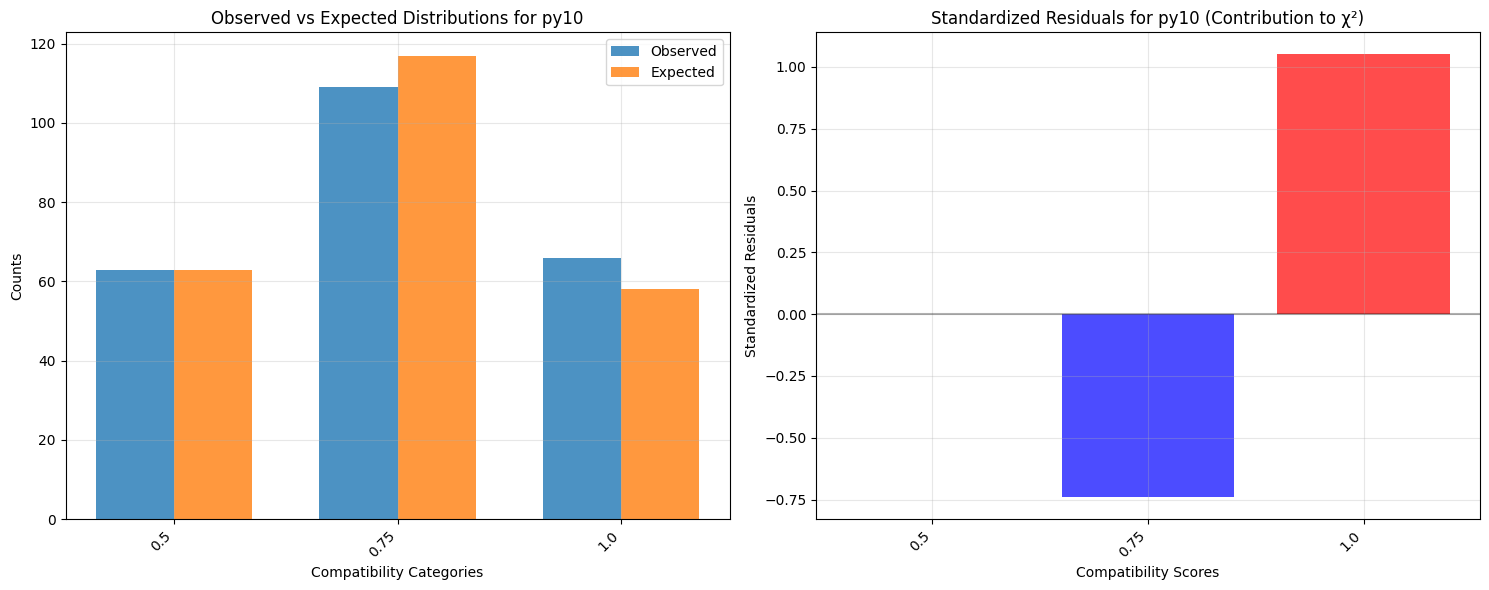

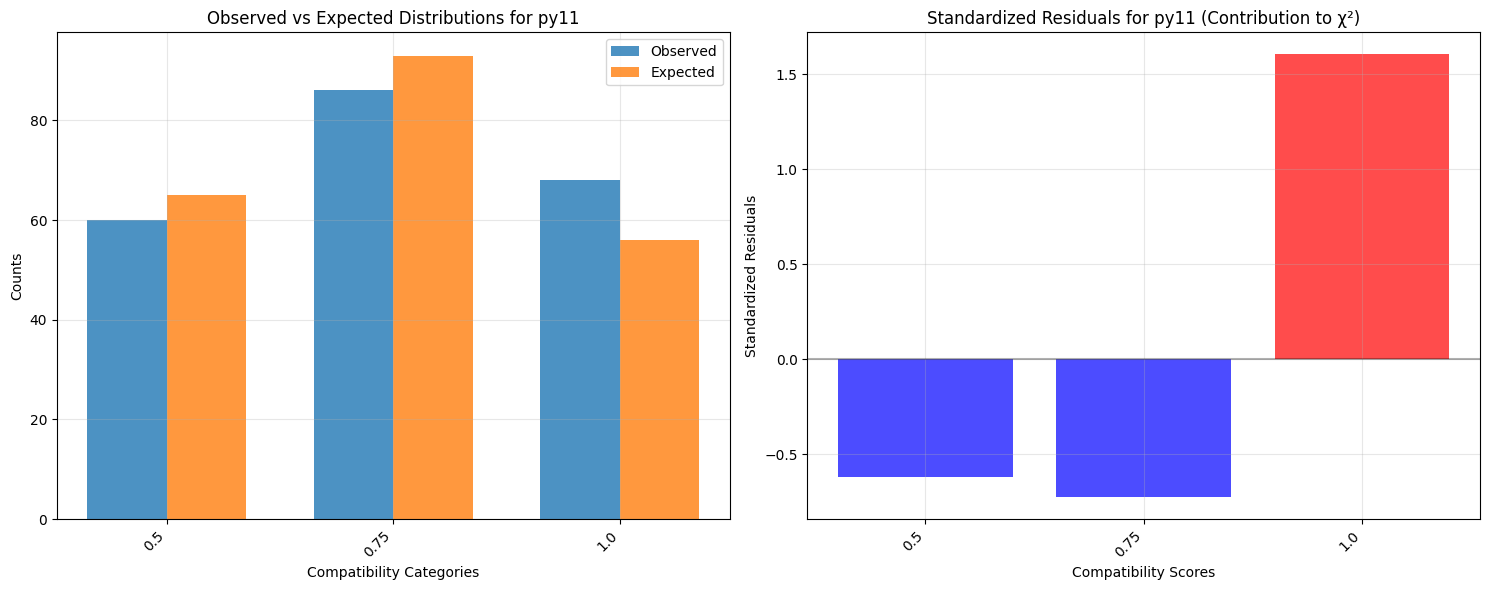

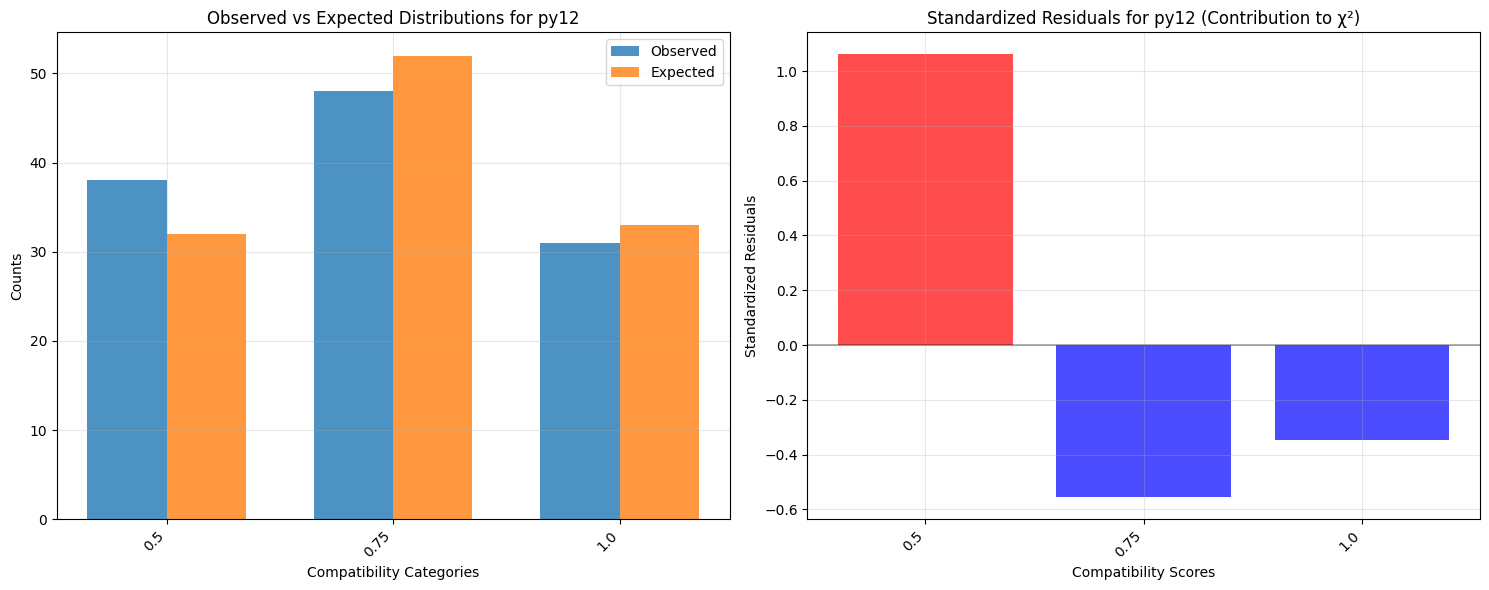

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from src.stats_comp import compatibility_play, compatibility_canticum
from src.utils.utils import make_chisquare_test

from results import victory_odes

chisquare_dict = {}
for responsion_attribute in tqdm(victory_odes):
    if responsion_attribute[:2] == "ol":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_olympians_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "py":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_pythians_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "ne":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_nemeans_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "is":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_isthmians_triads.xml', responsion_attribute)

    all_comp_baseline_scores = compatibility_play(f'data/compiled/baselines/triads/prose/baseline_prose_{responsion_attribute}.xml')

    # Output
    chi2_stat, degrees_of_freedom, p_value, sorted_keys, obs_counts, obs_total, exp_counts = make_chisquare_test(all_comp_scores, all_comp_baseline_scores)
    
    # Convert NumPy types to native Python types INSIDE the loop
    chisquare_dict[responsion_attribute] = (
        float(chi2_stat),           # Convert np.float64 to float
        int(degrees_of_freedom),    # Convert to int
        float(p_value),            # Convert np.float64 to float
        list(sorted_keys),          # Ensure it's a list
        obs_counts.tolist(),       # Convert numpy array to list
        int(obs_total),            # Convert np.int64 to int
        exp_counts.tolist()        # Convert numpy array to list
    )

    # ------------------------------ #
    # Visualize distributions        #
    # ------------------------------ #

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Bar chart comparing observed vs expected
    x_pos = np.arange(len(sorted_keys))
    width = 0.35

    bars1 = ax1.bar(x_pos - width/2, obs_counts, width, label='Observed', alpha=0.8)
    bars2 = ax1.bar(x_pos + width/2, exp_counts, width, label='Expected', alpha=0.8)

    ax1.set_xlabel('Compatibility Categories')
    ax1.set_ylabel('Counts')
    ax1.set_title(f'Observed vs Expected Distributions for {responsion_attribute}')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(sorted_keys, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Residuals (contribution to chi-square)
    residuals = (obs_counts - exp_counts) / np.sqrt(exp_counts)
    colors = ['red' if r > 0 else 'blue' for r in residuals]

    bars3 = ax2.bar(x_pos, residuals, color=colors, alpha=0.7)
    ax2.set_xlabel('Compatibility Scores')
    ax2.set_ylabel('Standardized Residuals')
    ax2.set_title(f'Standardized Residuals for {responsion_attribute} (Contribution to χ²)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(sorted_keys, rotation=45, ha='right')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'media/significance/chisquare_{responsion_attribute}.png')







# # Write to file with consistent formatting
# with open("results.py", "a", encoding="utf-8") as f:
#     f.write("\node_chisquare = {\n")
#     for key, value in chisquare_dict.items():
#         chi2_stat, dof, p_val, keys, obs, total, exp = value
#         f.write(f"    '{key}': ({chi2_stat:.6f}, {dof}, {p_val:.2e}, "
#                 f"{keys}, {obs}, {total}, {exp}),\n")
#     f.write("}\n")